# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow  seaborn

In [87]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn

# Features
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.manifold import Isomap

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [159]:
opt = {
    'image_size': 32,
    
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [160]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [161]:
# Loading the dataset
# eg.
dirpath = ['./dataset/IMFDB/', './dataset/IIIT-CFW/', './dataset/Yale_face_database/']

X_IMFDB,y_IMFDB = load_data(dirpath[0])
X_CFW,y_CFW = load_data(dirpath[1])
X_Yale,y_Yale = load_data(dirpath[2])
N_IMFDB,H_IMFDB,W_IMFDB = X_IMFDB.shape[0:3]
C_IMFDB = 1 if opt['is_grayscale'] else X_IMFDB.shape[3]
N_CFW,H_CFW,W_CFW = X_CFW.shape[0:3]
C_CFW = 1 if opt['is_grayscale'] else X_CFW.shape[3]
N_Yale,H_Yale,W_Yale = X_Yale.shape[0:3]
C_Yale = 1 if opt['is_grayscale'] else X_Yale.shape[3]

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


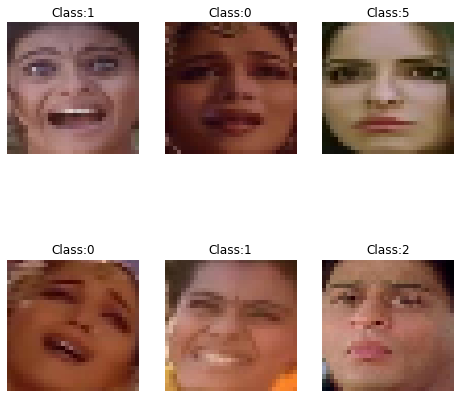

In [162]:
# Show sample images
ind = np.random.randint(0,y_IMFDB.shape[0],6)
disply_images(X_IMFDB[ind,...],y_IMFDB[ind], row=2,col=3)

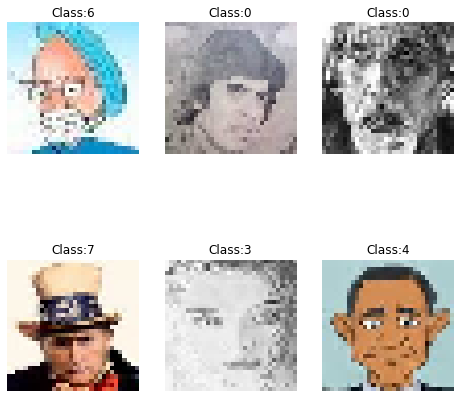

In [163]:
# Show sample images
ind = np.random.randint(0,y_CFW.shape[0],6)
disply_images(X_CFW[ind,...],y_CFW[ind], row=2,col=3)

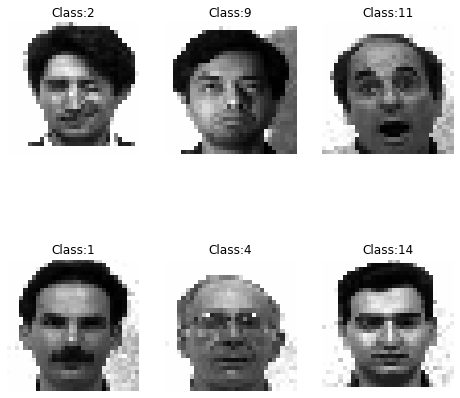

In [164]:
# Show sample images
ind = np.random.randint(0,y_Yale.shape[0],6)
disply_images(X_Yale[ind,...],y_Yale[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [165]:
# Flatten to apply PCA/LDA
X_IMFDB = X_IMFDB.reshape((N_IMFDB,H_IMFDB*W_IMFDB*C_IMFDB))

In [166]:
X_CFW = X_CFW.reshape((N_CFW,H_CFW*W_CFW*C_CFW))

In [167]:
X_Yale = X_Yale.reshape((N_Yale,H_Yale*W_Yale*C_Yale))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [168]:
def get_pca(X,k,req_inverse = False, req_transform = False):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    
    if req_inverse is True:
        X_reconstruct = pca.inverse_transform(X_k)
        return X_k, X_reconstruct
    elif req_transform is True:
        return X_k, pca
    else:
        return X_k, None

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [169]:
def get_kernel_pca(X, k,kernel='rbf', degree=3, req_inverse = False, req_transform = False):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree, fit_inverse_transform=req_inverse)
    X_k = kpca.fit_transform(X)
    if req_inverse is True:
        X_reconstruct = kpca.inverse_transform(X_k)
        return X_k, X_reconstruct
    elif req_transform is True:
        return X_k, kpca
    else:
        return X_k, None

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [170]:
def get_lda(X,y, k, req_inverse = False, solver = 'svd', req_transform = False):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k, solver = solver)
    X_k = lda.fit_transform(X,y)
    if req_inverse is True:
        inv = np.linalg.pinv(lda.scalings_[:,0:k])
        if lda.solver == 'svd':
            X_reconstruct = np.dot(X_k, inv) + lda.xbar_
        elif lda.solver == 'eigen':
            X_reconstruct = np.dot(X_k, inv)
        return X_k, X_reconstruct
    elif req_transform is True:
        return X_k, lda
    else:
        return X_k, None

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [171]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3, req_inverse = False, solver = 'svd', req_transform = False):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k, solver = solver)
    X_k = klda.fit_transform(X_transformed,y)
    if req_inverse is True:
        inv = np.linalg.pinv(klda.scalings_[:,0:k])
        if klda.solver == 'svd':
            X_reconstruct = np.dot(X_k, inv) + klda.xbar_
        elif klda.solver == 'eigen':
            X_reconstruct = np.dot(X_k, inv)
        return X_k, X_reconstruct
    elif req_transform is True:
        return X_k, klda
    else:
        return X_k, None

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [172]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [173]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)
- In a collection of human face images in a dataset, it is sometimes useful to measure the variances and use them to extract meaningful features. Since we know of dimensionality reduction techniques like PCA which utilise covariance to project data into the dimensions with maximum variance, we can similarly take a face dataset and project it into dimensions that represent useful information to problem setting (like maximising variance as in PCA and LDA) 
- Eigenfaces are the eigenvectors corresponding to the dimensions of maximal variance in a human face dataset 

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [174]:
# Compute your features 
# eg.
X_IMFDB_3D,_ = get_pca(X_IMFDB,3)
X_CFW_3D,_ = get_pca(X_CFW,3)
X_Yale_3D,_ = get_pca(X_Yale,3)

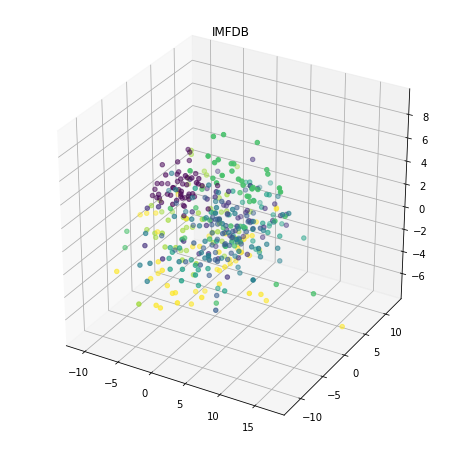

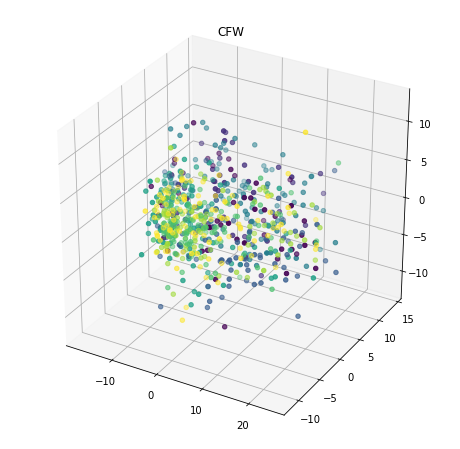

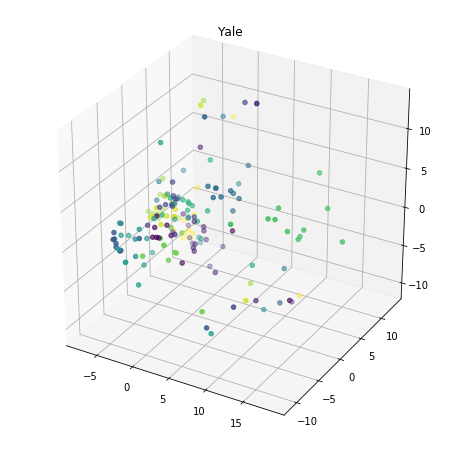

In [146]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_IMFDB_3D[:,0],X_IMFDB_3D[:,1],X_IMFDB_3D[:,2], c=y_IMFDB)
ax.set_title('IMFDB')
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_CFW_3D[:,0],X_CFW_3D[:,1],X_CFW_3D[:,2], c=y_CFW)
ax.set_title('CFW')
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_Yale_3D[:,0],X_Yale_3D[:,1],X_Yale_3D[:,2], c=y_Yale)
ax.set_title('Yale')
plt.show()

The number of eigen values required for 90% variance is =  69


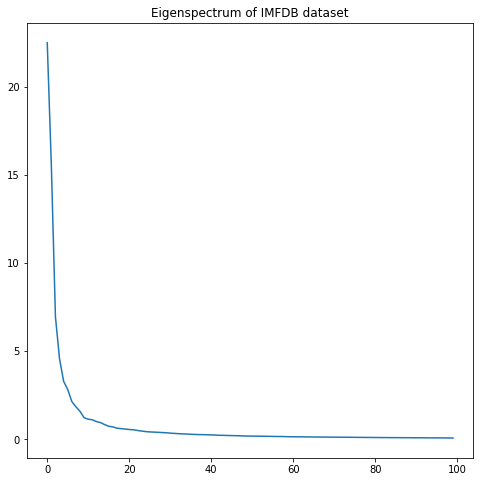

The number of eigen values required for 90% variance is =  205


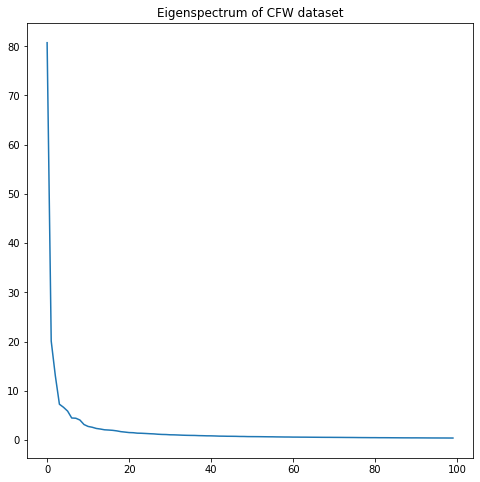

The number of eigen values required for 90% variance is =  34


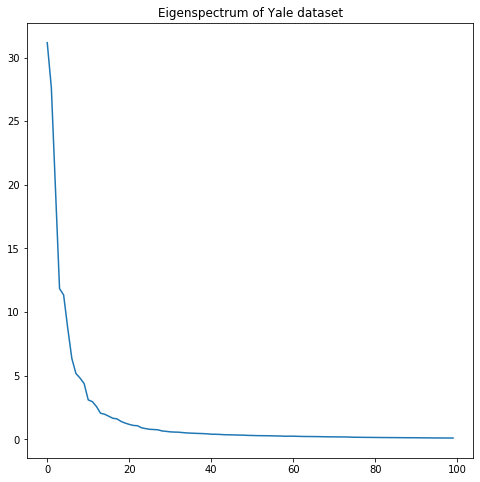

In [189]:
# Plot the eigen value spectrum 
face_eig_vals, face_eig_vecs = linalg.eig(np.cov(X_IMFDB.T))
idx = len(np.where(np.round(0.9*np.sum(face_eig_vals)) >= np.cumsum(face_eig_vals))[0])
print('The number of eigen values required for 90% variance is = ',idx)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.real(face_eig_vals[0:100]))
ax.set_title('Eigenspectrum of IMFDB dataset')
# print(face_eig_vals[0:20])
plt.show()

face_eig_vals, face_eig_vecs = linalg.eig(np.cov(X_CFW.T))
# Plot the eigen value spectrum 
idx = len(np.where(np.round(0.9*np.sum(face_eig_vals)) >= np.cumsum(face_eig_vals))[0])
print('The number of eigen values required for 90% variance is = ',idx)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.real(face_eig_vals[0:100]))
ax.set_title('Eigenspectrum of CFW dataset')
# print(face_eig_vals[0:20])
plt.show()

face_eig_vals, face_eig_vecs = linalg.eig(np.cov(X_Yale.T))
# Plot the eigen value spectrum 
idx = len(np.where(np.round(0.9*np.sum(face_eig_vals)) >= np.cumsum(face_eig_vals))[0])
print('The number of eigen values required for 90% variance is = ',idx)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(np.real(face_eig_vals[0:100]))
ax.set_title('Eigenspectrum of Yale dataset')
# print(face_eig_vals[0:20])
plt.show()

1(c). Reconstruct  the  image  back for each case


In [20]:
# def reconstruct_images(<input_parameters>,*args,**kwargs):
def reconstruct_images(X, y, k, method = 'pca', solver = 'svd'):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
#     pass
#     reconstruct_X = 
    if method is 'pca':
        X_k,reconstruct_X = get_pca(X,k,req_inverse=True)
    elif method is 'kpca':
        X_k,reconstruct_X = get_kernel_pca(X,k,req_inverse=True)
    elif method is 'lda':
        X_k,reconstruct_X = get_lda(X,y,k,req_inverse=True, solver = solver)
    elif method is 'klda':
        X_k,reconstruct_X = get_kernel_lda(X,y,k,req_inverse=True, solver= solver)
    
    if reconstruct_X is None:
        print('Check Syntax')
    else:
        return reconstruct_X    
    
def project_images(X, y, k, method = 'pca', solver = 'svd', req_transform = True):
    """
        Project the images by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return X_k => projected image
        
    """
    
#     pass
#     reconstruct_X =
    print('Projected using ', method,'\n')
    if method is 'pca':
        
        X_k,model = get_pca(X,k,req_transform=req_transform)
    elif method is 'kpca':
        X_k,model = get_kernel_pca(X,k,req_transform=req_transform)
    elif method is 'lda':
        X_k,model = get_lda(X,y,k, solver = solver,req_transform=req_transform)
    elif method is 'klda':
        X_k,model = get_kernel_lda(X,y,k, solver= solver,req_transform=req_transform)
    
    return X_k,model

Dataset =  IMFDB dataset
Error of reconstruction using PCA =  0.05391274689980564


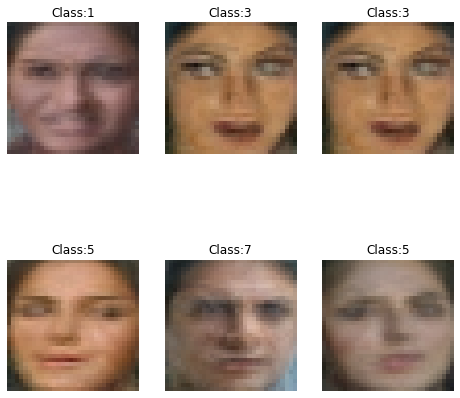

Dataset =  CFW dataset
Error of reconstruction using PCA =  0.09729750062519142


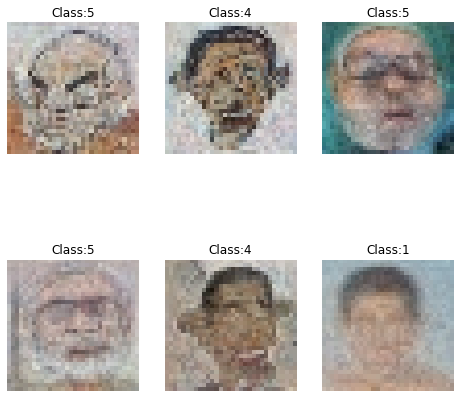

Dataset =  Yale dataset
Error of reconstruction using PCA =  0.0773810814985002


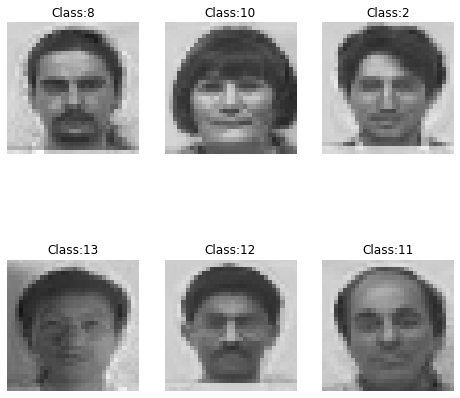

In [190]:
def results_of_reconstruction_pca(X, y, N, H, W, C, k, dataset):
    # Display results
    print('Dataset = ', dataset)
#     X = (X-np.min(X))/(np.max(X)-np.min(X))
    X_reconstructed_pca = reconstruct_images(X, y, k, 'pca')

    # Show the reconstruction error
    ind = np.random.randint(0,y.shape[0],6)
    print('Error of reconstruction using PCA = ',np.sqrt(np.mean((X - X_reconstructed_pca)**2)))

    # Display random images
    # X_norm = (X-np.min(X))/(np.max(X)-np.max(X))
#     X_reconstructed_pca = (X_reconstructed_pca - np.min(X_reconstructed_pca))/(np.max(X_reconstructed_pca)-np.min(X_reconstructed_pca))
    disply_images(((X_reconstructed_pca - np.min(X_reconstructed_pca))/(np.max(X_reconstructed_pca)-np.min(X_reconstructed_pca))).reshape(N,H,W,C)[ind,...],y[ind],row=2,col=3)
    return X_reconstructed_pca

X_IMFDB_reconstructed_pca = results_of_reconstruction_pca(X_IMFDB, y_IMFDB, N_IMFDB, H_IMFDB, W_IMFDB, C_IMFDB, 69, 'IMFDB dataset')
X_CFW_reconstructed_pca = results_of_reconstruction_pca(X_CFW, y_CFW, N_CFW, H_CFW, W_CFW, C_CFW, 205,'CFW dataset')
X_Yale_reconstructed_pca = results_of_reconstruction_pca(X_Yale, y_Yale, N_Yale, H_Yale, W_Yale, C_Yale, 34, 'Yale dataset')

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

- The persons per dataset who are difficult to represent will have maximum reconstruction error for their classes. For the given datasets, these are printed below the code
- Intuitively if we see in the dataset, we can see that the respective classes in each dataset have a lot of intra-class variance in terms of emotions, angle of face captured, closed and open eyes, lighting, so the results intuitively match to the empirical ones.
- Also, given to extreme variations in the Cartoonised dataset CFW, it is the hardest dataset to reconstruct while aiming for preserving minimum number of eigenvalues, hence it needs the maximum number of eigenvalues out of all datasets. 

In [191]:
# code goes here
def class_with_max_rec_error(ip_dict, X, X_reconstructed_pca, y, dataset):
    print('Dataset = ', dataset)
    rec_errors_pca = np.zeros(len(ip_dict))
    for i in range(len(ip_dict)):
        rec_errors_pca[i] = np.sqrt(np.mean((X[y==i,:] - X_reconstructed_pca[y==i,:])**2))
#     print('Class wise error => ',rec_errors_pca,'\n')
    idx_pca = np.argmax(rec_errors_pca)
    if (dataset is not 'Yale'):
        print('Using PCA, Class with highest reconstruction error = ',list(ip_dict.keys())[idx_pca], ',id = ', idx_pca)
    else:
        print('Using PCA, Class with highest reconstruction error = ',idx_pca)
    
class_with_max_rec_error(imfdb_dict, X_IMFDB, X_IMFDB_reconstructed_pca, y_IMFDB, 'IMFDB')
class_with_max_rec_error(cfw_dict, X_CFW, X_CFW_reconstructed_pca, y_CFW, 'CFW')
class_with_max_rec_error(range(1,16,1), X_Yale, X_Yale_reconstructed_pca, y_Yale, 'Yale')

Dataset =  IMFDB
Using PCA, Class with highest reconstruction error =  ShilpaShetty ,id =  3
Dataset =  CFW
Using PCA, Class with highest reconstruction error =  ManmohanSingh ,id =  6
Dataset =  Yale
Using PCA, Class with highest reconstruction error =  7


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

> I have used an MLP classifier with hidden layer sizes of (1000,1000), optimised with Adam and used ReLU activations 

2(b)Which method works well? Do a comparitive study. 

> I have used 10 different combinations of features per dataset. They are : 
- PCA
- LDA
- KLDA
- KPCA
- VGG
- VGG+PCA
- VGG+LDA
- ResNet
- ResNet+PCA 
- ResNet+LDA 

Here both the kernel methods, KPCA and KLDA use a Radial Basis Function.

You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [23]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self):
        super().__init__()
        self.clf = MLPClassifier(hidden_layer_sizes=(1000,1000), max_iter=1000, solver = 'adam', activation='relu')
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self, X):
        """
            Given an input X classify it into appropriate class. 
        """
        
#         self.clf.fit(X, y)
        prediction = self.clf.predict(X)
        return prediction
        
    def confusion_mat(self, pred, y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        return confusion_matrix(pred, y)
        
    def train(self, X_train, y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.clf.fit(X_train, y_train)
        
    def validate(self,X_train, y_train, X_validate, y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        self.train(X_train, y_train)
        pred_val = self.classify(X_validate)
        # Create a confusion matrix
        conf_mat = self.confusion_mat(pred_val, y_validate)
        # Calculate Validation accuracy 
        val_acc = self.clf.score(X_validate, y_validate)
        # Calculate precision and recall 
        prec = precision_score(y_validate, pred_val, average = 'macro')
        rec = recall_score(y_validate, pred_val, average = 'macro')
        # Calculate F1-score
        f1 = f1_score(y_validate, pred_val, average = 'macro')
    
        return conf_mat, val_acc, prec, rec, f1

In [24]:
# Create a train and validation split to train your classifier
def train_val_split(data, labels, test_size = 0.2, random_state = 42):
    data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size = test_size, random_state = random_state)
    
    return data_train, labels_train, data_val, labels_val

In [25]:
# Run classifier function

# Using raw input X
def show_stats(X_train, y_train, X_val, y_val, dataset, test_size = 0.2):
    print('Using ', dataset, ' dataset')
    clf = Classifier()
    clf.train(X_train, y_train)
    conf_mat, val_acc, prec, rec, f1 = clf.validate(X_train, y_train, X_val, y_val)
    print('Validation Accuracy = %.5f \nPrecision = %.5f \nRecall = %.5f \nF1 - Score = %.5f\n'%(val_acc, prec, rec, f1))
    sn.heatmap(conf_mat)
    plt.title('Confusion Matrix')
    plt.show()
    return conf_mat, val_acc, prec, rec, f1

In [26]:
def drive(X, y, k, dataset, projection1, projection2 = None, test_size = 0.2):
    if projection2 is None and (projection1 is not 'vgg' and projection1 is not 'resnet'):
        X_train, y_train, X_val, y_val = train_val_split(X,y, test_size=test_size)
        X_train_proj, proj_model = project_images(X_train, y_train, k, projection1)
        X_val_proj = proj_model.transform(X_val)
        print('Dimension = ',X_train_proj.shape)
        dimension = X_train_proj.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
    elif projection2 is None and (projection1 is 'vgg' or projection1 is 'resnet'):
        print('Using ',projection1, ' Only')
        X_train, y_train, X_val, y_val = train_val_split(X,y, test_size=test_size)
        print('Dimension = ',X_train.shape)
        dimension = X_train.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats(X_train, y_train, X_val, y_val, dataset, 0.1)
    elif projection2 is not None and projection1 is 'vgg':
        print('Using ',projection1, ' first')
        X_train, y_train, X_val, y_val = train_val_split(X,y, test_size=test_size)
        X_train_proj, proj_model = project_images(X_train, y_train, k, projection2)
        X_val_proj = proj_model.transform(X_val)
        print('Dimension = ',X_train_proj.shape)
        dimension = X_train_proj.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
    elif projection2 is not None and projection1 is 'resnet':
        print('Using ',projection1, ' first')
        X_train, y_train, X_val, y_val = train_val_split(X,y, test_size=test_size)
        X_train_proj, proj_model = project_images(X_train, y_train, k, projection2)
        X_val_proj = proj_model.transform(X_val)
        print('Dimension = ',X_train_proj.shape)
        dimension = X_train_proj.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
    return dimension, 100*val_acc, 100*(1-val_acc), prec, rec, f1

Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.83750 
Precision = 0.84013 
Recall = 0.85900 
F1 - Score = 0.83725



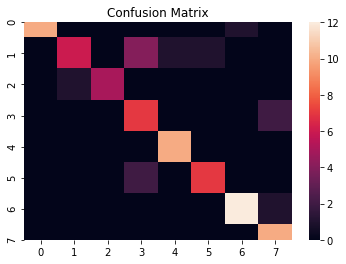

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.80000 
Precision = 0.80538 
Recall = 0.82679 
F1 - Score = 0.78911



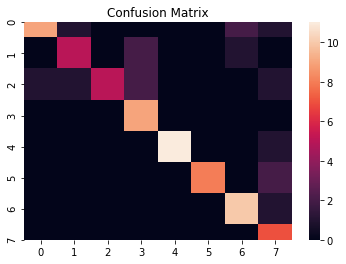

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset


/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation Accuracy = 0.15000 
Precision = 0.02174 
Recall = 0.11538 
F1 - Score = 0.03659



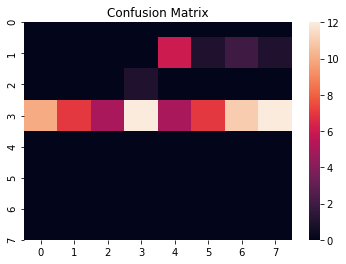

Projected using  kpca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.78750 
Precision = 0.79688 
Recall = 0.81326 
F1 - Score = 0.78542



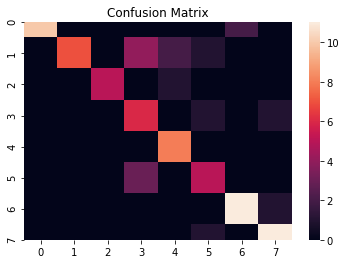

Using  vgg  Only
Dimension =  (320, 4096)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.88520 
Recall = 0.88208 
F1 - Score = 0.88322



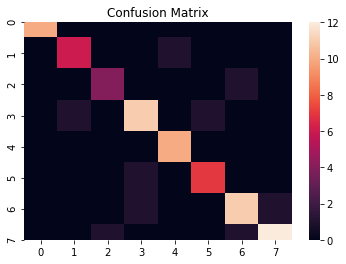

Using  vgg  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.90000 
Precision = 0.91410 
Recall = 0.89993 
F1 - Score = 0.90411



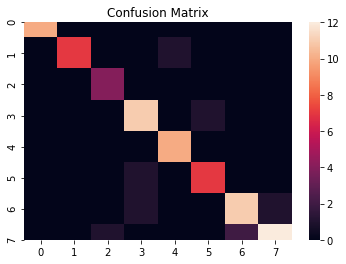

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.61250 
Precision = 0.71557 
Recall = 0.60399 
F1 - Score = 0.58953



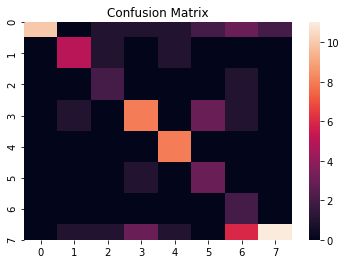

Using  resnet  Only
Dimension =  (320, 2048)
Using  IMFDB  dataset
Validation Accuracy = 0.95000 
Precision = 0.94593 
Recall = 0.94866 
F1 - Score = 0.94549



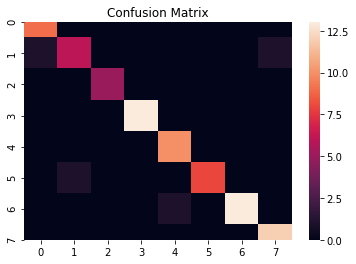

Using  resnet  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93483 
Recall = 0.93905 
F1 - Score = 0.93425



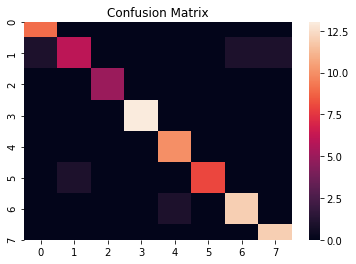

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.96250 
Precision = 0.97024 
Recall = 0.96116 
F1 - Score = 0.96445



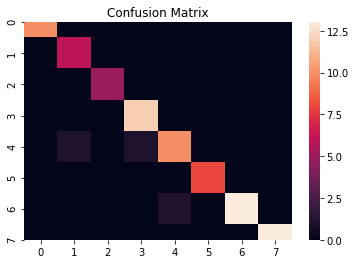

In [192]:
output_metrics = []
output_metrics.append(drive(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'pca', None))
output_metrics.append(drive(X_IMFDB, y_IMFDB, 7,  'IMFDB', 'lda', None))
output_metrics.append(drive(X_IMFDB, y_IMFDB, 7, 'IMFDB', 'klda', None))
output_metrics.append(drive(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'kpca', None))
output_metrics.append(drive(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg'))
output_metrics.append(drive(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg', 'pca'))
output_metrics.append(drive(get_vgg_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'vgg', 'lda'))
output_metrics.append(drive(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet'))
output_metrics.append(drive(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet', 'pca'))
output_metrics.append(drive(get_resnet_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'resnet', 'lda'))

In [193]:
output_metrics_IMFDB = output_metrics
projections = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df = pd.DataFrame(data = np.asarray(output_metrics_IMFDB), index = projections, columns = columns)
print(df)

            Dimension  Accuracy  Error  Precision    Recall  F1 score
PCA              69.0     83.75  16.25   0.840132  0.859000  0.837246
LDA               7.0     80.00  20.00   0.805383  0.826786  0.789108
KLDA              7.0     15.00  85.00   0.021739  0.115385  0.036585
KPCA             69.0     78.75  21.25   0.796875  0.813265  0.785423
VGG            4096.0     88.75  11.25   0.885199  0.882077  0.883215
VGG+PCA          69.0     90.00  10.00   0.914103  0.899934  0.904112
VGG+LDA           7.0     61.25  38.75   0.715575  0.603993  0.589528
ResNet         2048.0     95.00   5.00   0.945933  0.948664  0.945486
ResNet+PCA       69.0     93.75   6.25   0.934829  0.939048  0.934250
ResNet+LDA        7.0     96.25   3.75   0.970238  0.961164  0.964451


Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.58519 
Precision = 0.57691 
Recall = 0.60360 
F1 - Score = 0.58479



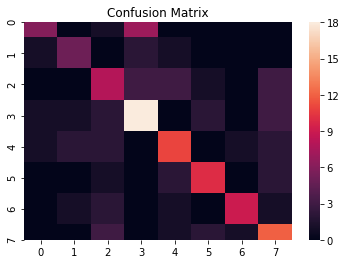

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.36296 
Precision = 0.38333 
Recall = 0.36437 
F1 - Score = 0.36259



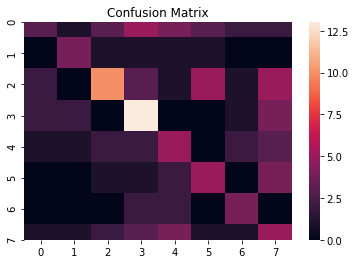

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset


/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation Accuracy = 0.15556 
Precision = 0.06359 
Recall = 0.13106 
F1 - Score = 0.08528



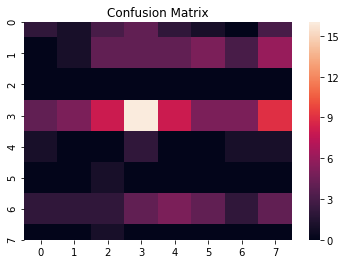

Projected using  kpca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.52593 
Precision = 0.50299 
Recall = 0.52770 
F1 - Score = 0.50877



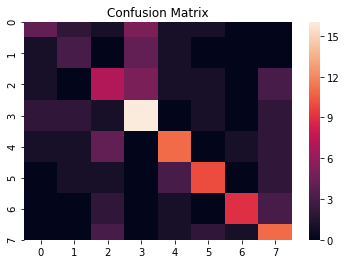

Using  vgg  Only
Dimension =  (537, 4096)
Using  CFW  dataset
Validation Accuracy = 0.60000 
Precision = 0.57749 
Recall = 0.55927 
F1 - Score = 0.55898



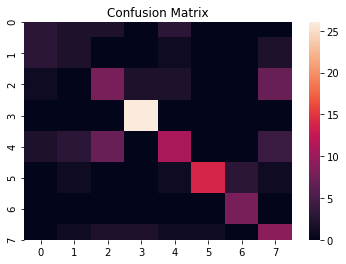

Using  vgg  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.70370 
Precision = 0.67982 
Recall = 0.65738 
F1 - Score = 0.66100



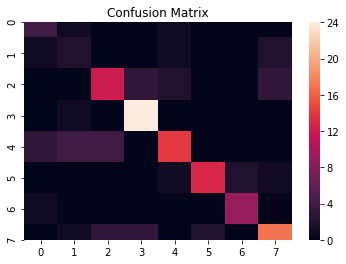

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.60741 
Precision = 0.56524 
Recall = 0.54486 
F1 - Score = 0.54501



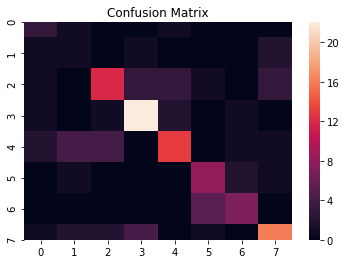

Using  resnet  Only
Dimension =  (537, 2048)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97050 
Recall = 0.97724 
F1 - Score = 0.97337



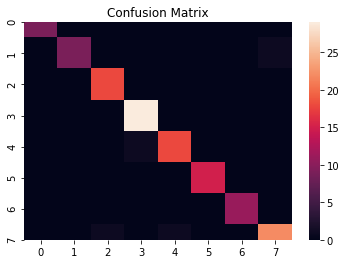

Using  resnet  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.97778 
Precision = 0.97582 
Recall = 0.98382 
F1 - Score = 0.97928



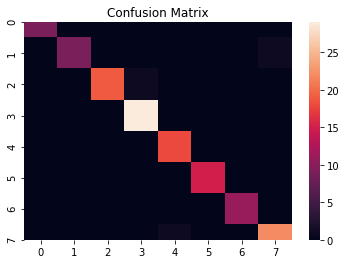

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97328 
Recall = 0.97246 
F1 - Score = 0.97210



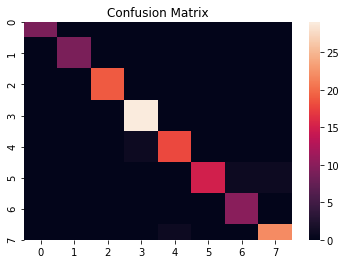

In [194]:
output_metrics_CFW = []
output_metrics_CFW.append(drive(X_CFW, y_CFW, 205, 'CFW', 'pca', None))
output_metrics_CFW.append(drive(X_CFW, y_CFW, 7,  'CFW', 'lda', None))
output_metrics_CFW.append(drive(X_CFW, y_CFW, 7, 'CFW', 'klda', None))
output_metrics_CFW.append(drive(X_CFW, y_CFW, 205, 'CFW', 'kpca', None))
output_metrics_CFW.append(drive(get_vgg_features(dirpath[1]), y_CFW, 205, 'CFW', 'vgg'))
output_metrics_CFW.append(drive(get_vgg_features(dirpath[1]), y_CFW,205, 'CFW', 'vgg', 'pca'))
output_metrics_CFW.append(drive(get_vgg_features(dirpath[1]), y_CFW, 7, 'CFW', 'vgg', 'lda'))
output_metrics_CFW.append(drive(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet'))
output_metrics_CFW.append(drive(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet', 'pca'))
output_metrics_CFW.append(drive(get_resnet_features(dirpath[1]), y_CFW, 7, 'CFW', 'resnet', 'lda'))

In [195]:
projections_CFW = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_CFW = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_CFW = pd.DataFrame(data = np.asarray(output_metrics_CFW), index = projections_CFW, columns = columns_CFW)
print(df_CFW)

            Dimension   Accuracy      Error  Precision    Recall  F1 score
PCA             205.0  58.518519  41.481481   0.576911  0.603601  0.584794
LDA               7.0  36.296296  63.703704   0.383326  0.364368  0.362585
KLDA              7.0  15.555556  84.444444   0.063588  0.131061  0.085278
KPCA            205.0  52.592593  47.407407   0.502994  0.527699  0.508766
VGG            4096.0  60.000000  40.000000   0.577488  0.559267  0.558977
VGG+PCA         205.0  70.370370  29.629630   0.679819  0.657383  0.660999
VGG+LDA           7.0  60.740741  39.259259   0.565242  0.544865  0.545006
ResNet         2048.0  97.037037   2.962963   0.970504  0.977241  0.973366
ResNet+PCA      205.0  97.777778   2.222222   0.975815  0.983820  0.979284
ResNet+LDA        7.0  97.037037   2.962963   0.973280  0.972456  0.972103


Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.78788 
Precision = 0.74405 
Recall = 0.77381 
F1 - Score = 0.72551



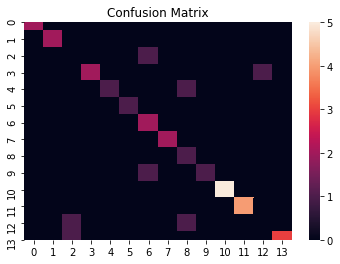

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.90909 
Precision = 0.92262 
Recall = 0.93452 
F1 - Score = 0.91548



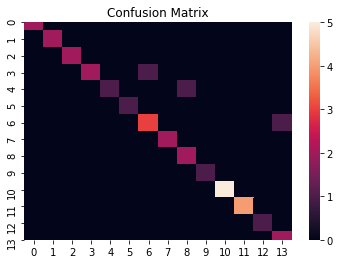

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (132, 14)
Using  Yale  dataset


/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation Accuracy = 0.06061 
Precision = 0.00433 
Recall = 0.07143 
F1 - Score = 0.00816



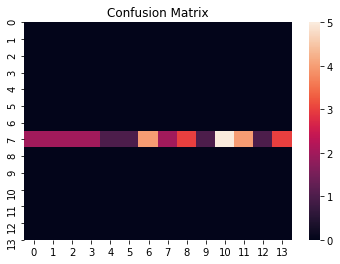

Projected using  kpca 

Dimension =  (132, 34)
Using  Yale  dataset


/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation Accuracy = 0.90909 
Precision = 0.83333 
Recall = 0.90476 
F1 - Score = 0.85238



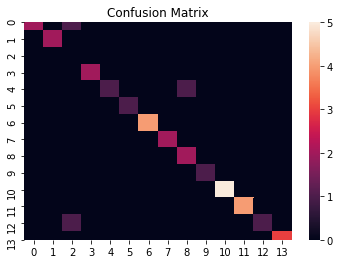

Using  vgg  Only
Dimension =  (132, 4096)
Using  Yale  dataset


/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Validation Accuracy = 0.57576 
Precision = 0.46778 
Recall = 0.48333 
F1 - Score = 0.44889



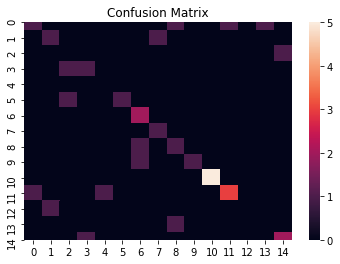

Using  vgg  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset


/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Validation Accuracy = 0.54545 
Precision = 0.60111 
Recall = 0.46667 
F1 - Score = 0.48222



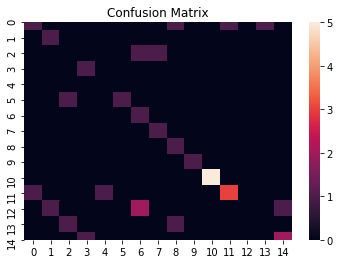

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (132, 14)
Using  Yale  dataset


/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Validation Accuracy = 0.54545 
Precision = 0.44444 
Recall = 0.52222 
F1 - Score = 0.46537



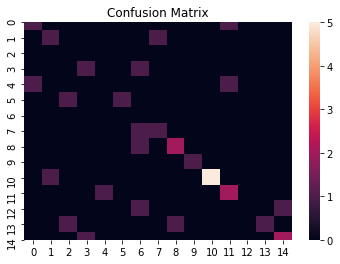

Using  resnet  Only
Dimension =  (132, 2048)
Using  Yale  dataset
Validation Accuracy = 0.96970 
Precision = 0.97619 
Recall = 0.98214 
F1 - Score = 0.97551



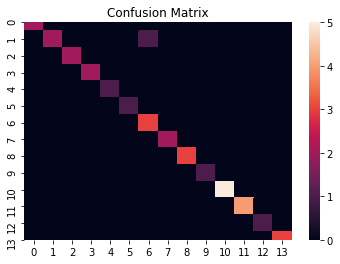

Using  resnet  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



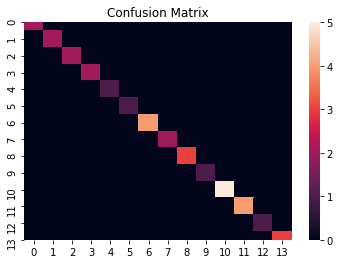

Using  resnet  first
Projected using  lda 

Dimension =  (132, 14)
Using  Yale  dataset


/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



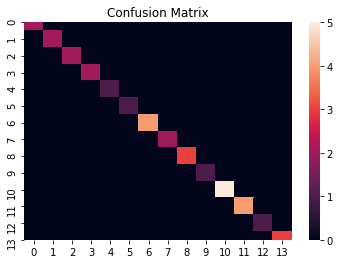

In [196]:
output_metrics_Yale = []
output_metrics_Yale.append(drive(X_Yale, y_Yale, 34, 'Yale', 'pca', None))
output_metrics_Yale.append(drive(X_Yale, y_Yale, 14,  'Yale', 'lda', None))
output_metrics_Yale.append(drive(X_Yale, y_Yale, 14, 'Yale', 'klda', None))
output_metrics_Yale.append(drive(X_Yale, y_Yale, 34, 'Yale', 'kpca', None))
output_metrics_Yale.append(drive(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg'))
output_metrics_Yale.append(drive(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg', 'pca'))
output_metrics_Yale.append(drive(get_vgg_features(dirpath[2]), y_Yale, 14, 'Yale', 'vgg', 'lda'))
output_metrics_Yale.append(drive(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet'))
output_metrics_Yale.append(drive(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet', 'pca'))
output_metrics_Yale.append(drive(get_resnet_features(dirpath[2]), y_Yale, 14, 'Yale', 'resnet', 'lda'))

In [197]:
projections_Yale = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_Yale = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_Yale = pd.DataFrame(data = np.asarray(output_metrics_Yale), index = projections_Yale, columns = columns_Yale)
print(df_Yale)

            Dimension    Accuracy      Error  Precision    Recall  F1 score
PCA              34.0   78.787879  21.212121   0.744048  0.773810  0.725510
LDA              14.0   90.909091   9.090909   0.922619  0.934524  0.915476
KLDA             14.0    6.060606  93.939394   0.004329  0.071429  0.008163
KPCA             34.0   90.909091   9.090909   0.833333  0.904762  0.852381
VGG            4096.0   57.575758  42.424242   0.467778  0.483333  0.448889
VGG+PCA          34.0   54.545455  45.454545   0.601111  0.466667  0.482222
VGG+LDA          14.0   54.545455  45.454545   0.444444  0.522222  0.465368
ResNet         2048.0   96.969697   3.030303   0.976190  0.982143  0.975510
ResNet+PCA       34.0  100.000000   0.000000   1.000000  1.000000  1.000000
ResNet+LDA       14.0  100.000000   0.000000   1.000000  1.000000  1.000000


In [198]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)
print('Comparison of different features on IMFDB Dataset')
print(df)
print(' ')
print('Comparison of different features on CFW Dataset')
print(df_CFW)
print(' ')
print('Comparison of different features on Yale Dataset')
print(df_Yale)
print(' ')

Comparison of different features on IMFDB Dataset
            Dimension  Accuracy  Error  Precision    Recall  F1 score
PCA              69.0     83.75  16.25   0.840132  0.859000  0.837246
LDA               7.0     80.00  20.00   0.805383  0.826786  0.789108
KLDA              7.0     15.00  85.00   0.021739  0.115385  0.036585
KPCA             69.0     78.75  21.25   0.796875  0.813265  0.785423
VGG            4096.0     88.75  11.25   0.885199  0.882077  0.883215
VGG+PCA          69.0     90.00  10.00   0.914103  0.899934  0.904112
VGG+LDA           7.0     61.25  38.75   0.715575  0.603993  0.589528
ResNet         2048.0     95.00   5.00   0.945933  0.948664  0.945486
ResNet+PCA       69.0     93.75   6.25   0.934829  0.939048  0.934250
ResNet+LDA        7.0     96.25   3.75   0.970238  0.961164  0.964451
 
Comparison of different features on CFW Dataset
            Dimension   Accuracy      Error  Precision    Recall  F1 score
PCA             205.0  58.518519  41.481481   0.576911 

Best model for each dataset
Using  resnet  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93700 
Recall = 0.93905 
F1 - Score = 0.93623



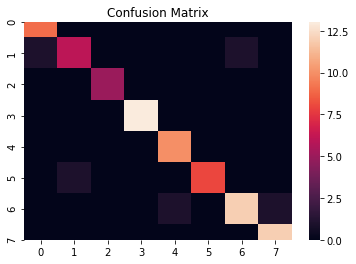

Using  resnet  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.97778 
Precision = 0.97549 
Recall = 0.98382 
F1 - Score = 0.97929



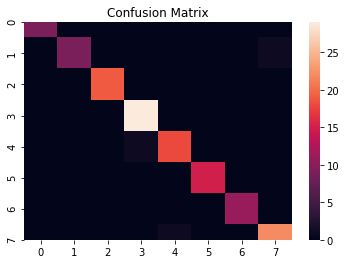

Using  resnet  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.93939 
Precision = 0.94048 
Recall = 0.94643 
F1 - Score = 0.92789



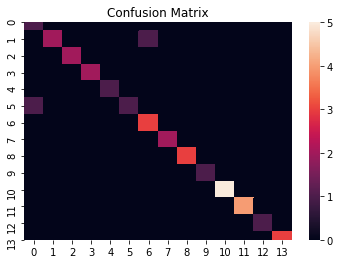

In [266]:
# For each dataset print the confusion matrix for the best model 
print('Best model for each dataset')
_, _, _, _, _, _ = drive(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet', 'pca')
_, _, _, _, _, _ = drive(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet', 'pca')
_, _, _, _, _, _ = drive(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet', 'pca')

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

> Usage of TSNE -
- TSNE is a non linear dimensionality reduction technique that converts distances between high-dimensional points into probability of similarity. 
- Then it tries to minimise the difference of similarities in higher and lower dimensional space using KL divergence of data points.
- Here I have used TSNE on PCA and LDA. 
- While PCA is not properly separable, LDA is separable and hence is a good feature for classification. 

Projected using  pca 

Projected using  pca 

Projected using  pca 



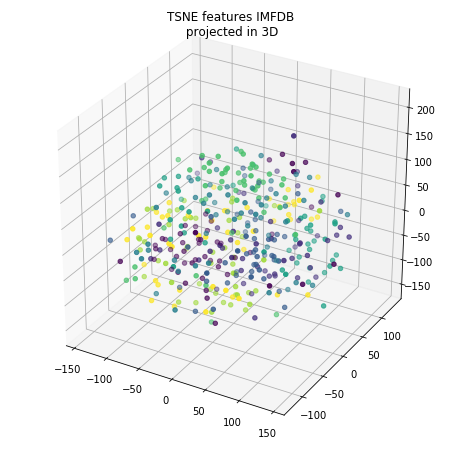

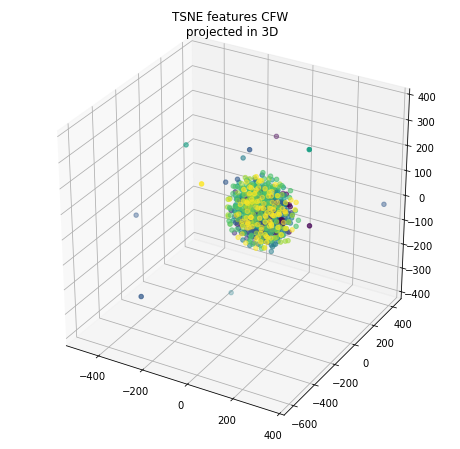

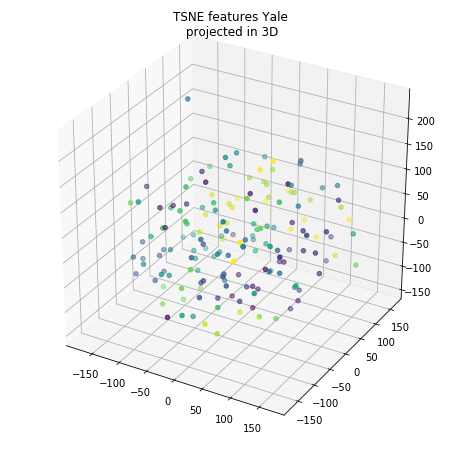

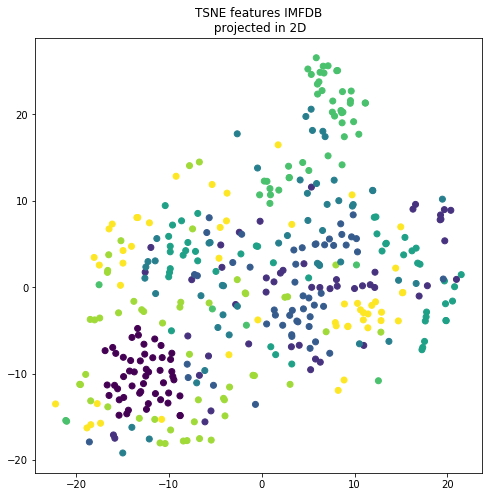

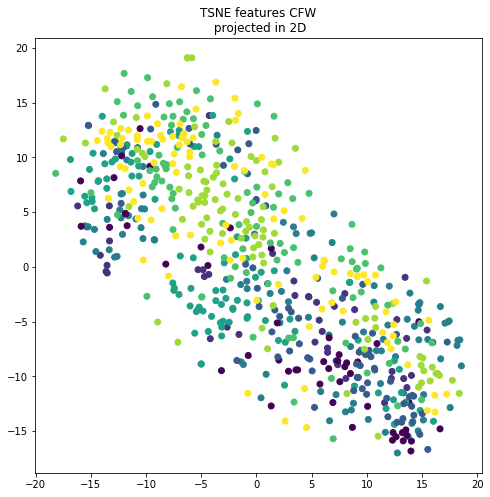

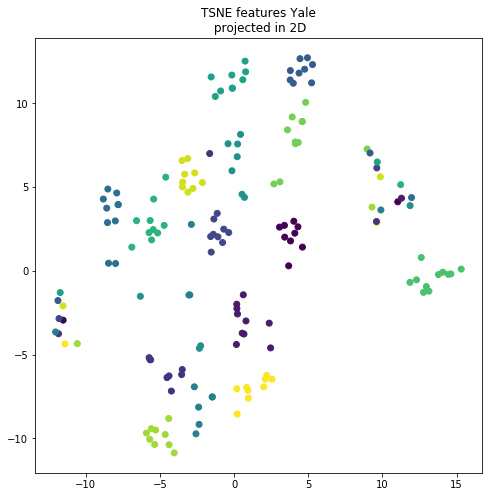

In [220]:
# Compute TSNE for different features and create a scatter plot

# X =  # feature 
# k = 3 # Number of components in TSNE

# Compute
def run_TSNE(X,y,dataset,k=3):
    X_TSNE = TSNE(n_components=k).fit_transform(X)
    fig = plt.figure(figsize=(30,30))
    if k == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2], c=y)
        ax.set_title('TSNE features '+dataset+ '\n projected in 3D')
    elif k == 2:
        ax = fig.add_subplot(111)
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1], c=y)
        ax.set_title('TSNE features '+dataset+ '\n projected in 2D')
    plt.show()
#     return X_TSNE

X_IMFDB_proj_pca,_ = project_images(X_IMFDB,y_IMFDB,69,'pca')
X_CFW_proj_pca,_ = project_images(X_CFW,y_CFW,205,'pca')
X_Yale_proj_pca,_ = project_images(X_Yale,y_Yale,34,'pca')

# print('Using PCA')
run_TSNE(X_IMFDB_proj_pca,y_IMFDB,'IMFDB')
run_TSNE(X_CFW_proj_pca,y_CFW,'CFW')
run_TSNE(X_Yale_proj_pca,y_Yale,'Yale')

run_TSNE(X_IMFDB_proj_pca,y_IMFDB,'IMFDB',2)
run_TSNE(X_CFW_proj_pca,y_CFW,'CFW',2)
run_TSNE(X_Yale_proj_pca,y_Yale,'Yale',2)
# Plot the representation in 2d/3d


Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


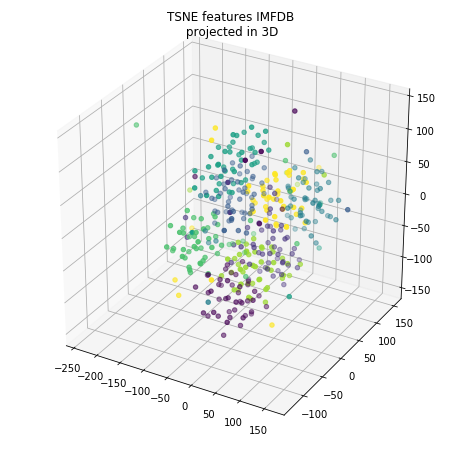

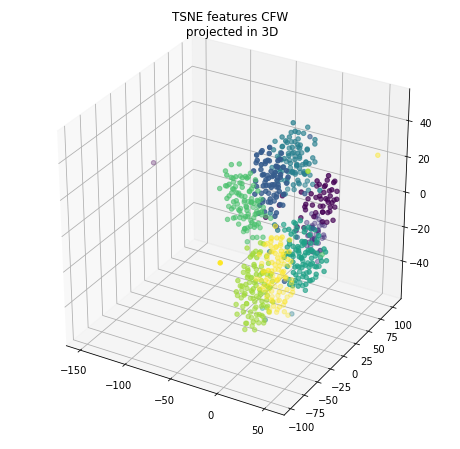

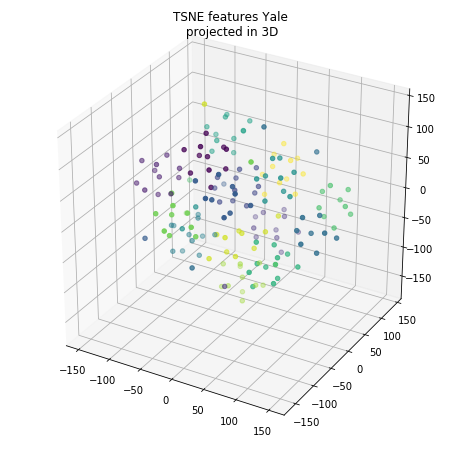

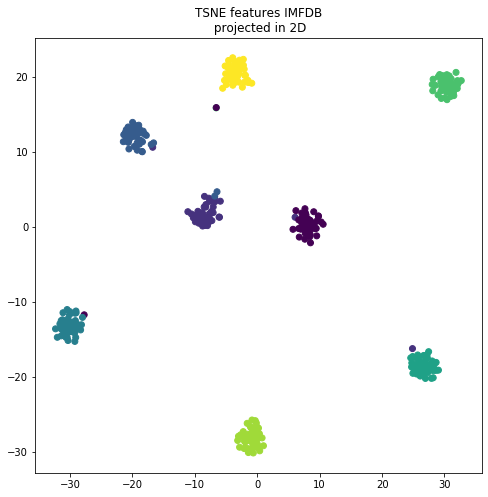

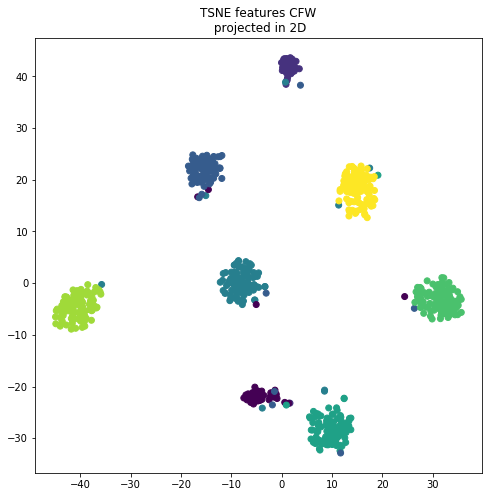

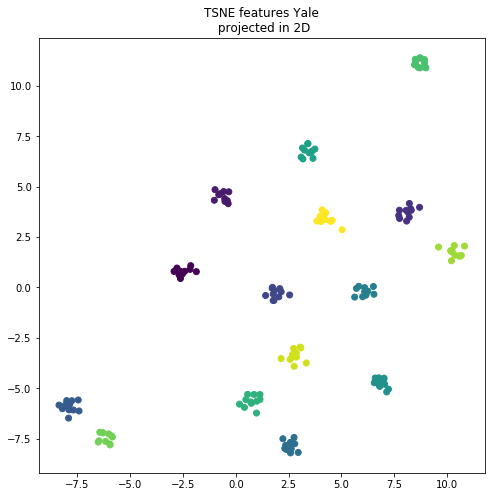

In [221]:
X_IMFDB_proj_lda,_ = project_images(X_IMFDB,y_IMFDB,7,'lda')
X_CFW_proj_lda,_ = project_images(X_CFW,y_CFW,7,'lda')
X_Yale_proj_lda,_ = project_images(X_Yale,y_Yale,14,'lda')

# print('Using PCA')
run_TSNE(X_IMFDB_proj_lda,y_IMFDB,'IMFDB')
run_TSNE(X_CFW_proj_lda,y_CFW,'CFW')
run_TSNE(X_Yale_proj_lda,y_Yale,'Yale')

run_TSNE(X_IMFDB_proj_lda,y_IMFDB,'IMFDB',2)
run_TSNE(X_CFW_proj_lda,y_CFW,'CFW',2)
run_TSNE(X_Yale_proj_lda,y_Yale,'Yale',2)
# Plot the representation in 2d/3d

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

>We use KNN as a classifier against features generated by popular dimensionality reduction  
algorithms like PCA and LDA and feature extractors like VGG and ResNet. Then against a query we check the class predicted and verify it with the preset class ID. 


4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

> To analyse the performance we can use different 
metrics like Classification accuracy, precision, 
recall, f1 score. Here accuracy is the most logical 
choice.
____________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [222]:
class FaceVerification():
    def __init__(self,k=None):
        super().__init__()
        if k is None:
            self.clf = KNeighborsClassifier()
        else:
            self.clf = KNeighborsClassifier(n_neighbors=k)
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        N = X.shape[0]
        pred = self.clf.predict(X)
        verfication_results = np.zeros(N)
        verfication_results[pred==class_id]=1
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.clf.fit(X_train, y_train)
        
    def validate(self,X_train, y_train, X_validate, y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        self.train(X_train, y_train)
        pred_val = self.clf.predict(X_validate)
        # Calculate Validation accuracy 
        val_acc = self.clf.score(X_validate, y_validate)
        # Calculate precision, recall and F1 score
        conf_mat = confusion_matrix(pred_val, y_validate)
        prec = precision_score(y_validate, pred_val, average = 'macro')
        rec = recall_score(y_validate, pred_val, average = 'macro')
        f1 = f1_score(y_validate, pred_val, average = 'macro')
    
        return conf_mat,val_acc, prec, rec, f1

In [223]:
# Create a train and validation split and show your results 
def train_val_split_KNN(data, labels, test_size = 0.2, random_state = 42):
    data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size = test_size, random_state = random_state)
    
    return data_train, labels_train, data_val, labels_val

In [224]:
def show_stats_KNN(X_train, y_train, X_val, y_val, dataset, test_size = 0.2, neighbours = None):
    print('Using ', dataset, ' dataset')
    clf = FaceVerification(k = neighbours)
    clf.train(X_train, y_train)
    conf_mat, val_acc, prec, rec, f1 = clf.validate(X_train, y_train, X_val, y_val)
    print('Validation Accuracy = %.5f \nPrecision = %.5f \nRecall = %.5f \nF1 - Score = %.5f\n'%(val_acc, prec, rec, f1))
    sn.heatmap(conf_mat)
    plt.title('Confusion Matrix')
    plt.show()
    return conf_mat, val_acc, prec, rec, f1

In [225]:
def drive_KNN(X, y, k, dataset, projection1, projection2 = None, test_size = 0.2, neighbours = None):
    if projection2 is None and (projection1 is not 'vgg' and projection1 is not 'resnet'):
        X_train, y_train, X_val, y_val = train_val_split_KNN(X,y, test_size=test_size)
        X_train_proj, proj_model = project_images(X_train, y_train, k, projection1)
        X_val_proj = proj_model.transform(X_val)
        print('Dimension = ',X_train_proj.shape)
        dimension = X_train_proj.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats_KNN(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
    elif projection2 is None and (projection1 is 'vgg' or projection1 is 'resnet'):
        print('Using ',projection1, ' Only')
        X_train, y_train, X_val, y_val = train_val_split_KNN(X,y, test_size=test_size)
        print('Dimension = ',X_train.shape)
        dimension = X_train.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats_KNN(X_train, y_train, X_val, y_val, dataset, 0.1)
    elif projection2 is not None and projection1 is 'vgg':
        print('Using ',projection1, ' first')
        X_train, y_train, X_val, y_val = train_val_split_KNN(X,y, test_size=test_size)
        X_train_proj, proj_model = project_images(X_train, y_train, k, projection2)
        X_val_proj = proj_model.transform(X_val)
        print('Dimension = ',X_train_proj.shape)
        dimension = X_train_proj.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats_KNN(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
    elif projection2 is not None and projection1 is 'resnet':
        print('Using ',projection1, ' first')
        X_train, y_train, X_val, y_val = train_val_split_KNN(X,y, test_size=test_size)
        X_train_proj, proj_model = project_images(X_train, y_train, k, projection2)
        X_val_proj = proj_model.transform(X_val)
        print('Dimension = ',X_train_proj.shape)
        dimension = X_train_proj.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats_KNN(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
    return dimension, 100*val_acc, 100*(1-val_acc), prec, rec, f1

Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.58750 
Precision = 0.69478 
Recall = 0.64545 
F1 - Score = 0.57687



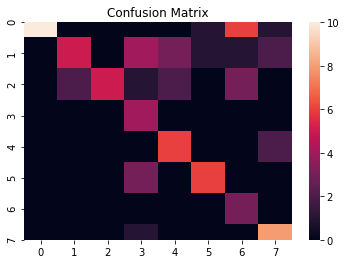

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.80000 
Precision = 0.79969 
Recall = 0.81765 
F1 - Score = 0.78908



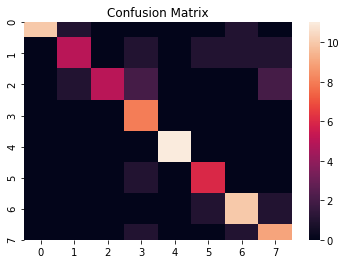

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.03750 
Precision = 0.00962 
Recall = 0.05357 
F1 - Score = 0.01630



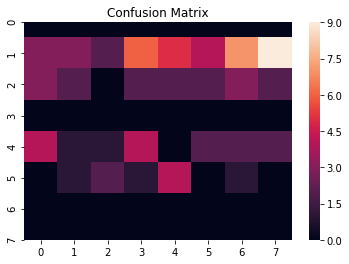

Projected using  kpca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.60000 
Precision = 0.71825 
Recall = 0.65506 
F1 - Score = 0.59713



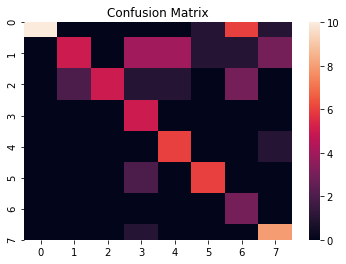

Using  vgg  Only
Dimension =  (320, 4096)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.87913 
Recall = 0.87384 
F1 - Score = 0.87435



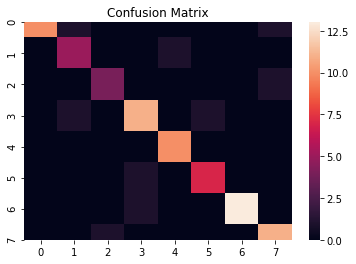

Using  vgg  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.87913 
Recall = 0.87384 
F1 - Score = 0.87435



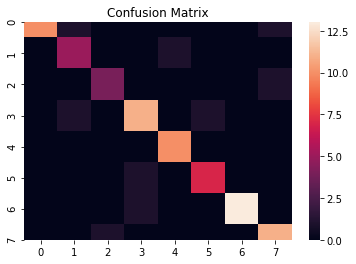

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.72500 
Precision = 0.72273 
Recall = 0.73442 
F1 - Score = 0.72025



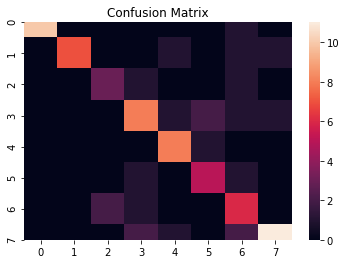

Using  resnet  Only
Dimension =  (320, 2048)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93864 
Recall = 0.93905 
F1 - Score = 0.93529



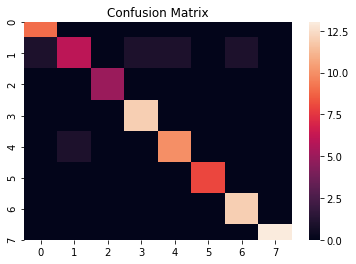

Using  resnet  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93864 
Recall = 0.93905 
F1 - Score = 0.93529



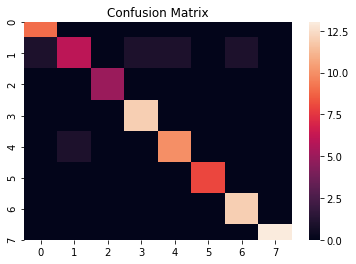

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.94464 
Recall = 0.93905 
F1 - Score = 0.94033



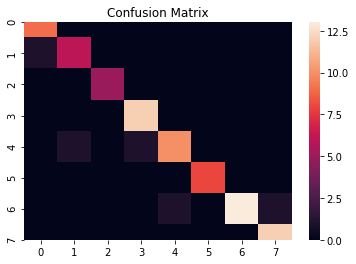

In [226]:
output_metrics_KNN = []
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'pca', None, neighbours = 3))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 7,  'IMFDB', 'lda', None, neighbours = 3))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 7, 'IMFDB', 'klda', None, neighbours = 3))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'kpca', None, neighbours = 3))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg', neighbours = 3))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg', 'pca', neighbours = 3))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'vgg', 'lda', neighbours = 3))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet', neighbours = 3))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet', 'pca', neighbours = 3))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'resnet', 'lda', neighbours = 3))

In [227]:
print('Using 3NN')
output_metrics_IMFDB_KNN = output_metrics_KNN
projections = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_IMFDB_KNN = pd.DataFrame(data = np.asarray(output_metrics_IMFDB_KNN), index = projections, columns = columns)
print(df_IMFDB_KNN)

Using 3NN
            Dimension  Accuracy  Error  Precision    Recall  F1 score
PCA              69.0     58.75  41.25   0.694778  0.645448  0.576868
LDA               7.0     80.00  20.00   0.799693  0.817651  0.789083
KLDA              7.0      3.75  96.25   0.009615  0.053571  0.016304
KPCA             69.0     60.00  40.00   0.718254  0.655064  0.597127
VGG            4096.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+PCA          69.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+LDA           7.0     72.50  27.50   0.722727  0.734419  0.720255
ResNet         2048.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+PCA       69.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+LDA        7.0     93.75   6.25   0.944643  0.939048  0.940331


Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.60000 
Precision = 0.71127 
Recall = 0.65506 
F1 - Score = 0.58999



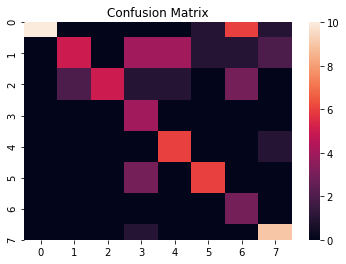

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.80000 
Precision = 0.79969 
Recall = 0.81765 
F1 - Score = 0.78908



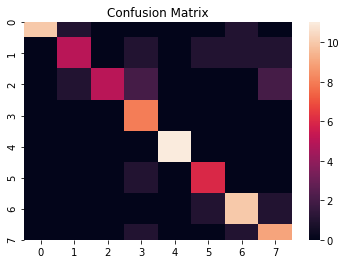

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.03750 
Precision = 0.00962 
Recall = 0.05357 
F1 - Score = 0.01630



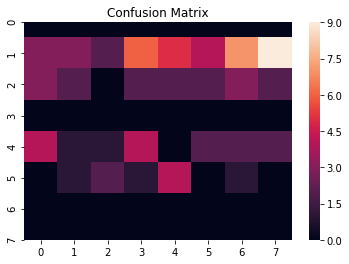

Projected using  kpca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.60000 
Precision = 0.71825 
Recall = 0.65506 
F1 - Score = 0.59713



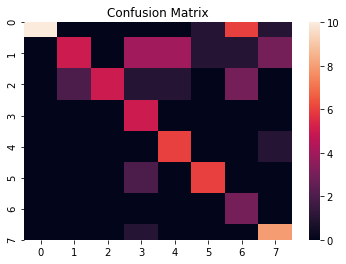

Using  vgg  Only
Dimension =  (320, 4096)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.87913 
Recall = 0.87384 
F1 - Score = 0.87435



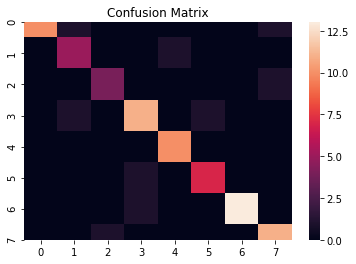

Using  vgg  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.87913 
Recall = 0.87384 
F1 - Score = 0.87435



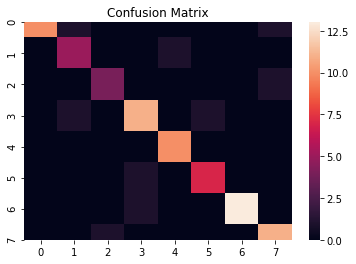

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.72500 
Precision = 0.72273 
Recall = 0.73442 
F1 - Score = 0.72025



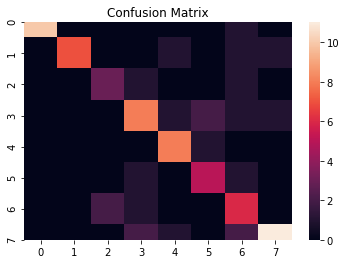

Using  resnet  Only
Dimension =  (320, 2048)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93864 
Recall = 0.93905 
F1 - Score = 0.93529



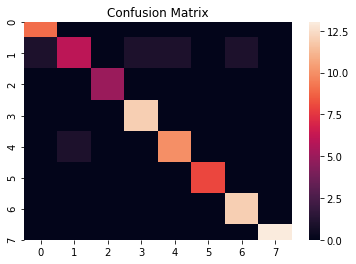

Using  resnet  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93864 
Recall = 0.93905 
F1 - Score = 0.93529



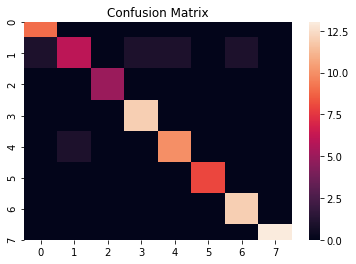

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.94464 
Recall = 0.93905 
F1 - Score = 0.94033



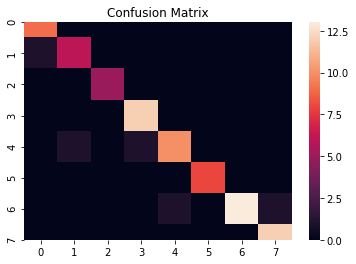

In [228]:
output_metrics_KNN = []
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'pca', None, neighbours = 5))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 7,  'IMFDB', 'lda', None, neighbours = 5))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 7, 'IMFDB', 'klda', None, neighbours = 5))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'kpca', None, neighbours = 5))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg', neighbours = 5))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg', 'pca', neighbours = 5))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'vgg', 'lda', neighbours = 5))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet', neighbours = 5))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet', 'pca', neighbours = 5))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'resnet', 'lda', neighbours = 5))

In [229]:
print('Using 5NN')
output_metrics_IMFDB_KNN = output_metrics_KNN
projections = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_IMFDB_KNN = pd.DataFrame(data = np.asarray(output_metrics_IMFDB_KNN), index = projections, columns = columns)
print(df_IMFDB_KNN)

Using 5NN
            Dimension  Accuracy  Error  Precision    Recall  F1 score
PCA              69.0     60.00  40.00   0.711269  0.655064  0.589992
LDA               7.0     80.00  20.00   0.799693  0.817651  0.789083
KLDA              7.0      3.75  96.25   0.009615  0.053571  0.016304
KPCA             69.0     60.00  40.00   0.718254  0.655064  0.597127
VGG            4096.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+PCA          69.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+LDA           7.0     72.50  27.50   0.722727  0.734419  0.720255
ResNet         2048.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+PCA       69.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+LDA        7.0     93.75   6.25   0.944643  0.939048  0.940331


Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.58750 
Precision = 0.70116 
Recall = 0.64545 
F1 - Score = 0.58316



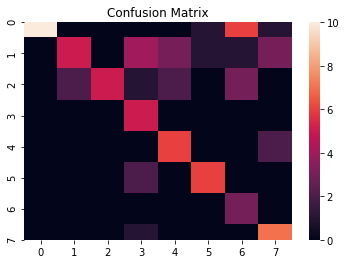

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.80000 
Precision = 0.79969 
Recall = 0.81765 
F1 - Score = 0.78908



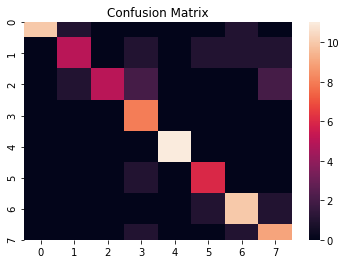

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.03750 
Precision = 0.00962 
Recall = 0.05357 
F1 - Score = 0.01630



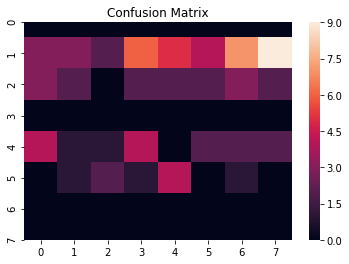

Projected using  kpca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.60000 
Precision = 0.71825 
Recall = 0.65506 
F1 - Score = 0.59713



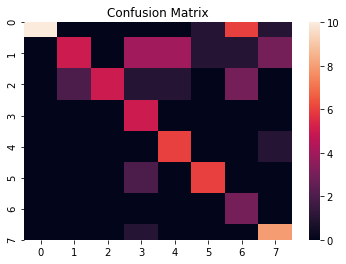

Using  vgg  Only
Dimension =  (320, 4096)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.87913 
Recall = 0.87384 
F1 - Score = 0.87435



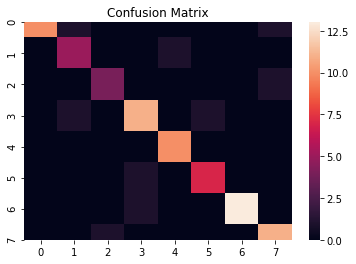

Using  vgg  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.87913 
Recall = 0.87384 
F1 - Score = 0.87435



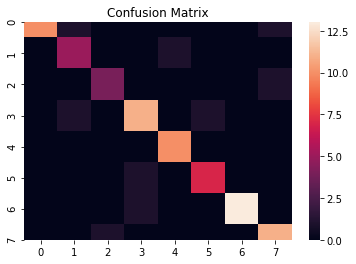

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.72500 
Precision = 0.72273 
Recall = 0.73442 
F1 - Score = 0.72025



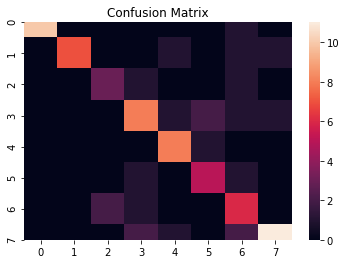

Using  resnet  Only
Dimension =  (320, 2048)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93864 
Recall = 0.93905 
F1 - Score = 0.93529



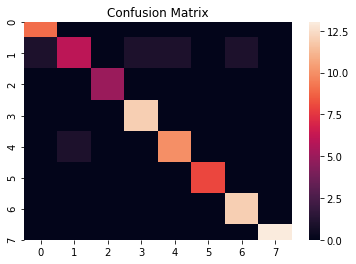

Using  resnet  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93864 
Recall = 0.93905 
F1 - Score = 0.93529



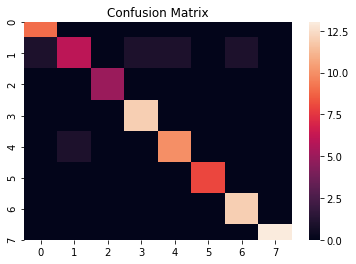

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.94464 
Recall = 0.93905 
F1 - Score = 0.94033



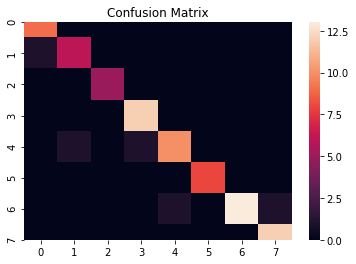

In [230]:
output_metrics_KNN = []
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'pca', None, neighbours = 7))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 7,  'IMFDB', 'lda', None, neighbours = 7))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 7, 'IMFDB', 'klda', None, neighbours = 7))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'kpca', None, neighbours = 7))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg', neighbours = 7))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg', 'pca', neighbours = 7))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'vgg', 'lda', neighbours = 7))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet', neighbours = 7))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet', 'pca', neighbours = 7))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'resnet', 'lda', neighbours = 7))

In [231]:
print('Using 7NN')
output_metrics_IMFDB_KNN = output_metrics_KNN
projections = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_IMFDB_KNN = pd.DataFrame(data = np.asarray(output_metrics_IMFDB_KNN), index = projections, columns = columns)
print(df_IMFDB_KNN)

Using 7NN
            Dimension  Accuracy  Error  Precision    Recall  F1 score
PCA              69.0     58.75  41.25   0.701161  0.645448  0.583164
LDA               7.0     80.00  20.00   0.799693  0.817651  0.789083
KLDA              7.0      3.75  96.25   0.009615  0.053571  0.016304
KPCA             69.0     60.00  40.00   0.718254  0.655064  0.597127
VGG            4096.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+PCA          69.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+LDA           7.0     72.50  27.50   0.722727  0.734419  0.720255
ResNet         2048.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+PCA       69.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+LDA        7.0     93.75   6.25   0.944643  0.939048  0.940331


Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.60000 
Precision = 0.67795 
Recall = 0.65506 
F1 - Score = 0.59433



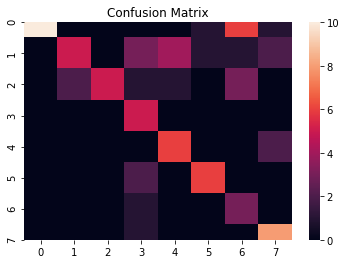

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.80000 
Precision = 0.79969 
Recall = 0.81765 
F1 - Score = 0.78908



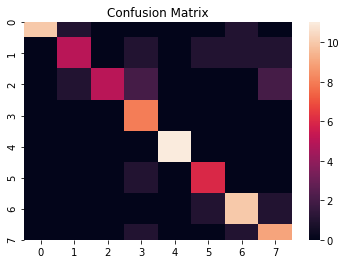

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.03750 
Precision = 0.00962 
Recall = 0.05357 
F1 - Score = 0.01630



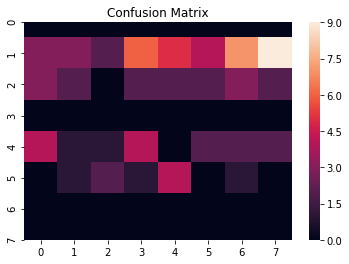

Projected using  kpca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.60000 
Precision = 0.71825 
Recall = 0.65506 
F1 - Score = 0.59713



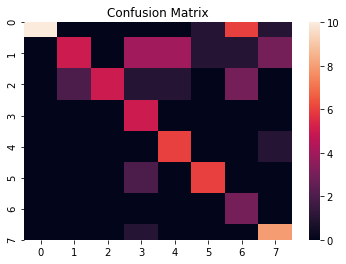

Using  vgg  Only
Dimension =  (320, 4096)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.87913 
Recall = 0.87384 
F1 - Score = 0.87435



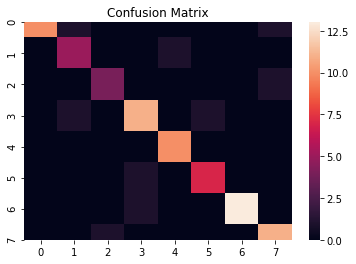

Using  vgg  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.87913 
Recall = 0.87384 
F1 - Score = 0.87435



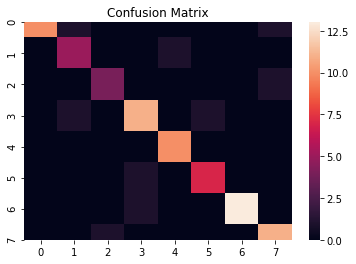

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.72500 
Precision = 0.72273 
Recall = 0.73442 
F1 - Score = 0.72025



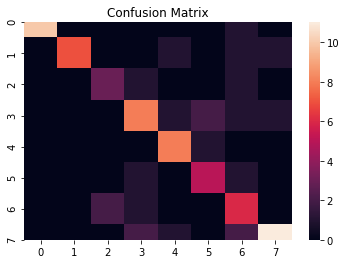

Using  resnet  Only
Dimension =  (320, 2048)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93864 
Recall = 0.93905 
F1 - Score = 0.93529



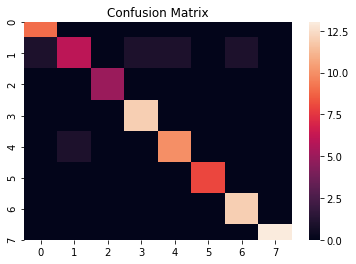

Using  resnet  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.93864 
Recall = 0.93905 
F1 - Score = 0.93529



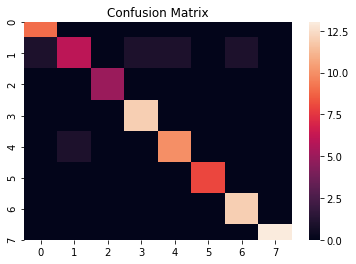

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 7)
Using  IMFDB  dataset
Validation Accuracy = 0.93750 
Precision = 0.94464 
Recall = 0.93905 
F1 - Score = 0.94033



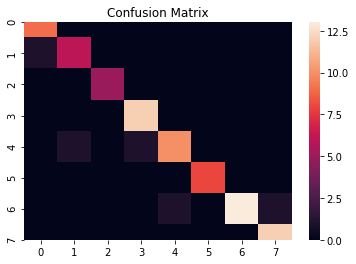

In [232]:
output_metrics_KNN = []
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'pca', None))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 7,  'IMFDB', 'lda', None))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 7, 'IMFDB', 'klda', None))
output_metrics_KNN.append(drive_KNN(X_IMFDB, y_IMFDB, 69, 'IMFDB', 'kpca', None))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg'))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'vgg', 'pca'))
output_metrics_KNN.append(drive_KNN(get_vgg_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'vgg', 'lda'))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet'))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 69, 'IMFDB', 'resnet', 'pca'))
output_metrics_KNN.append(drive_KNN(get_resnet_features(dirpath[0]), y_IMFDB, 7, 'IMFDB', 'resnet', 'lda'))

In [233]:
print('Without preselected K for KNN')
output_metrics_IMFDB_KNN = output_metrics_KNN
projections = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_IMFDB_KNN = pd.DataFrame(data = np.asarray(output_metrics_IMFDB_KNN), index = projections, columns = columns)
print(df_IMFDB_KNN)

Without preselected K for KNN
            Dimension  Accuracy  Error  Precision    Recall  F1 score
PCA              69.0     60.00  40.00   0.677951  0.655064  0.594332
LDA               7.0     80.00  20.00   0.799693  0.817651  0.789083
KLDA              7.0      3.75  96.25   0.009615  0.053571  0.016304
KPCA             69.0     60.00  40.00   0.718254  0.655064  0.597127
VGG            4096.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+PCA          69.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+LDA           7.0     72.50  27.50   0.722727  0.734419  0.720255
ResNet         2048.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+PCA       69.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+LDA        7.0     93.75   6.25   0.944643  0.939048  0.940331


Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.33333 
Precision = 0.38068 
Recall = 0.34104 
F1 - Score = 0.31186



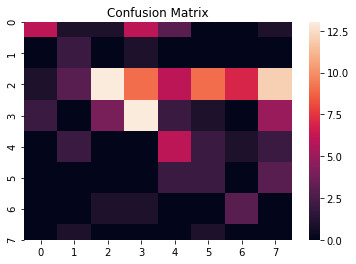

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.31111 
Precision = 0.31362 
Recall = 0.29448 
F1 - Score = 0.29267



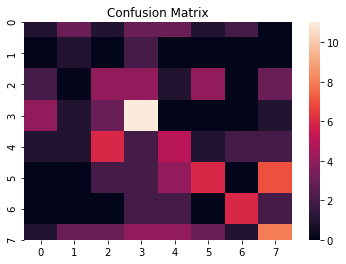

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.20000 
Precision = 0.07556 
Recall = 0.14408 
F1 - Score = 0.07789



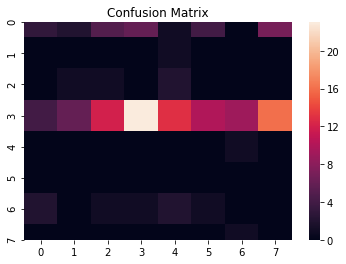

Projected using  kpca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.32593 
Precision = 0.42444 
Recall = 0.33446 
F1 - Score = 0.31206



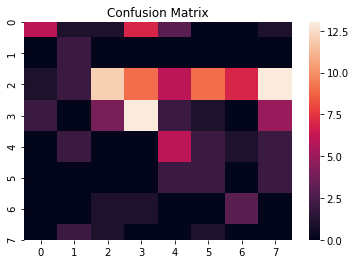

Using  vgg  Only
Dimension =  (537, 4096)
Using  CFW  dataset
Validation Accuracy = 0.68148 
Precision = 0.67335 
Recall = 0.64748 
F1 - Score = 0.64862



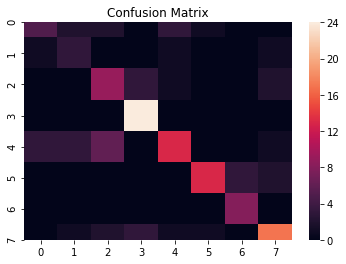

Using  vgg  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.68148 
Precision = 0.67335 
Recall = 0.64748 
F1 - Score = 0.64862



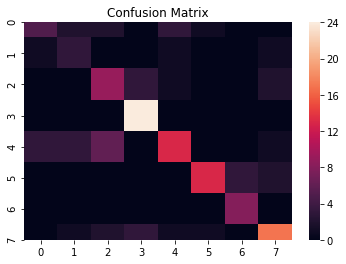

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.63704 
Precision = 0.56768 
Recall = 0.56909 
F1 - Score = 0.56564



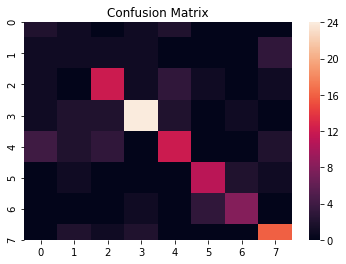

Using  resnet  Only
Dimension =  (537, 2048)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97328 
Recall = 0.97246 
F1 - Score = 0.97210



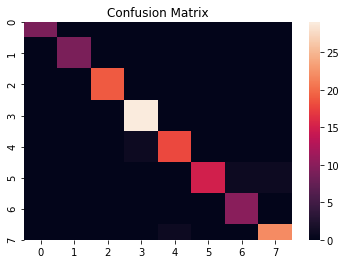

Using  resnet  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97328 
Recall = 0.97246 
F1 - Score = 0.97210



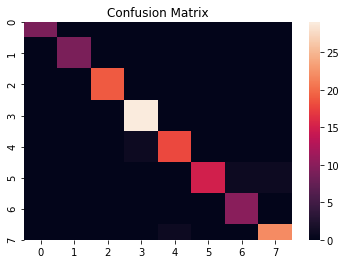

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97488 
Recall = 0.97246 
F1 - Score = 0.97276



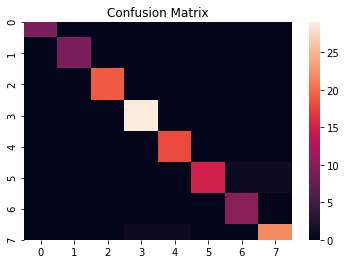

In [234]:
output_metrics_CFW_KNN = []
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 205, 'CFW', 'pca', None, neighbours = 3))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 7,  'CFW', 'lda', None, neighbours = 3))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 7, 'CFW', 'klda', None, neighbours = 3))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 205, 'CFW', 'kpca', None, neighbours = 3))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 205, 'CFW', 'vgg', neighbours = 3))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 205, 'CFW', 'vgg', 'pca', neighbours = 3))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 7, 'CFW', 'vgg', 'lda', neighbours = 3))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet', neighbours = 3))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet', 'pca', neighbours = 3))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 7, 'CFW', 'resnet', 'lda', neighbours = 3))

In [235]:
print('Using 3NN')
projections_CFW = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_CFW = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_CFW_KNN = pd.DataFrame(data = np.asarray(output_metrics_CFW_KNN), index = projections_CFW, columns = columns_CFW)
print(df_CFW_KNN)

Using 3NN
            Dimension   Accuracy      Error  Precision    Recall  F1 score
PCA             205.0  33.333333  66.666667   0.380675  0.341035  0.311856
LDA               7.0  31.111111  68.888889   0.313624  0.294482  0.292665
KLDA              7.0  20.000000  80.000000   0.075557  0.144079  0.077888
KPCA            205.0  32.592593  67.407407   0.424442  0.334456  0.312065
VGG            4096.0  68.148148  31.851852   0.673355  0.647482  0.648618
VGG+PCA         205.0  68.148148  31.851852   0.673355  0.647482  0.648618
VGG+LDA           7.0  63.703704  36.296296   0.567677  0.569094  0.565641
ResNet         2048.0  97.037037   2.962963   0.973280  0.972456  0.972103
ResNet+PCA      205.0  97.037037   2.962963   0.973280  0.972456  0.972103
ResNet+LDA        7.0  97.037037   2.962963   0.974877  0.972456  0.972759


Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.32593 
Precision = 0.41721 
Recall = 0.33687 
F1 - Score = 0.30970



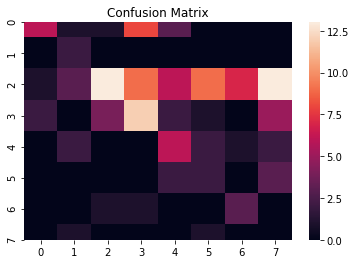

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.31111 
Precision = 0.31362 
Recall = 0.29448 
F1 - Score = 0.29267



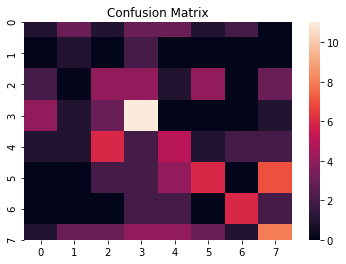

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.20000 
Precision = 0.07556 
Recall = 0.14408 
F1 - Score = 0.07789



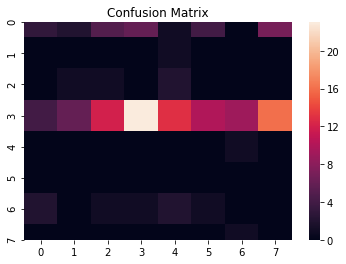

Projected using  kpca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.32593 
Precision = 0.42444 
Recall = 0.33446 
F1 - Score = 0.31206



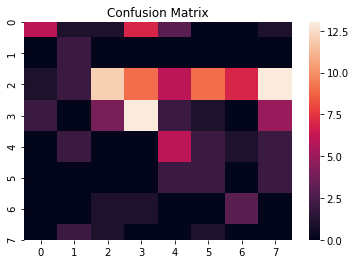

Using  vgg  Only
Dimension =  (537, 4096)
Using  CFW  dataset
Validation Accuracy = 0.68148 
Precision = 0.67335 
Recall = 0.64748 
F1 - Score = 0.64862



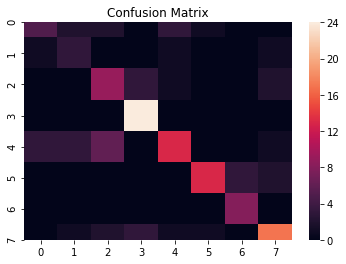

Using  vgg  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.68148 
Precision = 0.67335 
Recall = 0.64748 
F1 - Score = 0.64862



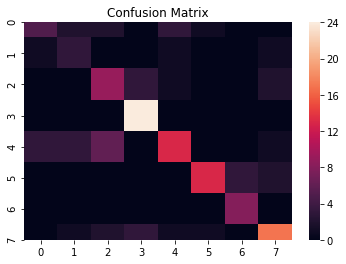

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.63704 
Precision = 0.56768 
Recall = 0.56909 
F1 - Score = 0.56564



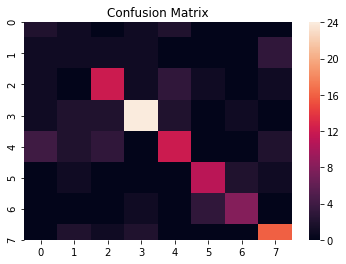

Using  resnet  Only
Dimension =  (537, 2048)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97328 
Recall = 0.97246 
F1 - Score = 0.97210



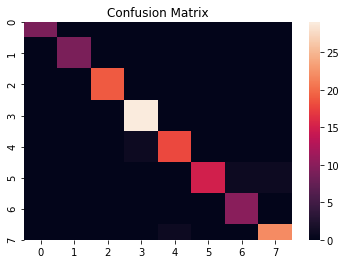

Using  resnet  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97328 
Recall = 0.97246 
F1 - Score = 0.97210



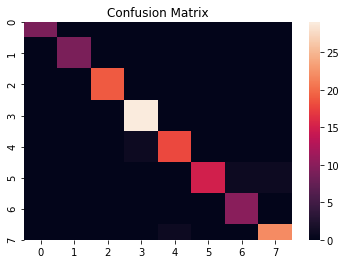

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97488 
Recall = 0.97246 
F1 - Score = 0.97276



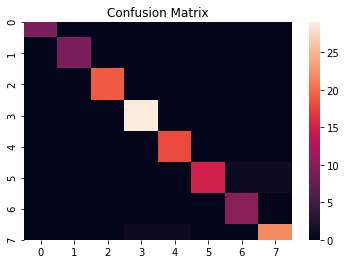

In [236]:
output_metrics_CFW_KNN = []
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 205, 'CFW', 'pca', None, neighbours = 5))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 7,  'CFW', 'lda', None, neighbours = 5))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 7, 'CFW', 'klda', None, neighbours = 5))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 205, 'CFW', 'kpca', None, neighbours = 5))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 205, 'CFW', 'vgg', neighbours = 5))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 205, 'CFW', 'vgg', 'pca', neighbours = 5))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 7, 'CFW', 'vgg', 'lda', neighbours = 5))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet', neighbours = 5))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet', 'pca', neighbours = 5))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 7, 'CFW', 'resnet', 'lda', neighbours = 5))

In [237]:
print('Using 5NN')
projections_CFW = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_CFW = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_CFW_KNN = pd.DataFrame(data = np.asarray(output_metrics_CFW_KNN), index = projections_CFW, columns = columns_CFW)
print(df_CFW_KNN)

Using 5NN
            Dimension   Accuracy      Error  Precision    Recall  F1 score
PCA             205.0  32.592593  67.407407   0.417212  0.336869  0.309700
LDA               7.0  31.111111  68.888889   0.313624  0.294482  0.292665
KLDA              7.0  20.000000  80.000000   0.075557  0.144079  0.077888
KPCA            205.0  32.592593  67.407407   0.424442  0.334456  0.312065
VGG            4096.0  68.148148  31.851852   0.673355  0.647482  0.648618
VGG+PCA         205.0  68.148148  31.851852   0.673355  0.647482  0.648618
VGG+LDA           7.0  63.703704  36.296296   0.567677  0.569094  0.565641
ResNet         2048.0  97.037037   2.962963   0.973280  0.972456  0.972103
ResNet+PCA      205.0  97.037037   2.962963   0.973280  0.972456  0.972103
ResNet+LDA        7.0  97.037037   2.962963   0.974877  0.972456  0.972759


Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.33333 
Precision = 0.38820 
Recall = 0.34104 
F1 - Score = 0.31406



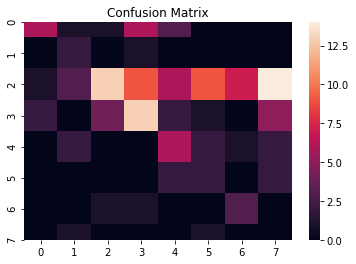

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.31111 
Precision = 0.31362 
Recall = 0.29448 
F1 - Score = 0.29267



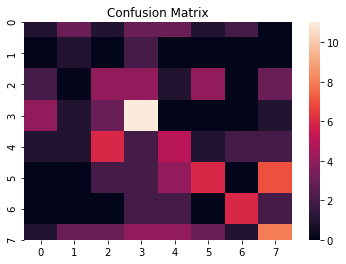

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.20000 
Precision = 0.07556 
Recall = 0.14408 
F1 - Score = 0.07789



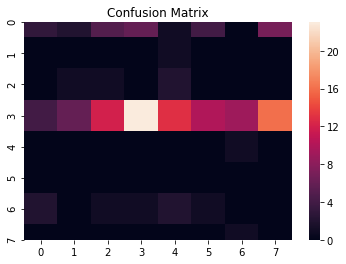

Projected using  kpca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.32593 
Precision = 0.42444 
Recall = 0.33446 
F1 - Score = 0.31206



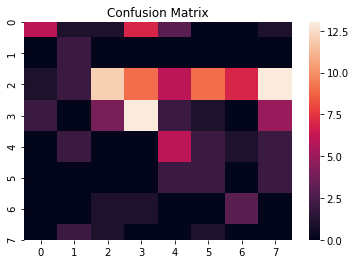

Using  vgg  Only
Dimension =  (537, 4096)
Using  CFW  dataset
Validation Accuracy = 0.68148 
Precision = 0.67335 
Recall = 0.64748 
F1 - Score = 0.64862



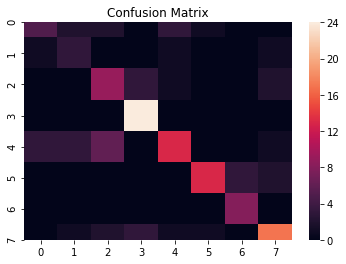

Using  vgg  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.68148 
Precision = 0.67335 
Recall = 0.64748 
F1 - Score = 0.64862



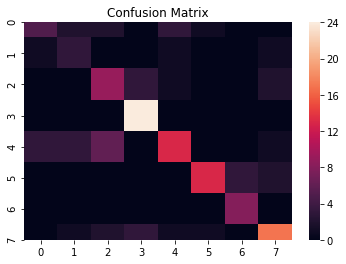

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.63704 
Precision = 0.56768 
Recall = 0.56909 
F1 - Score = 0.56564



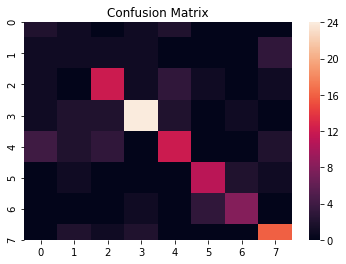

Using  resnet  Only
Dimension =  (537, 2048)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97328 
Recall = 0.97246 
F1 - Score = 0.97210



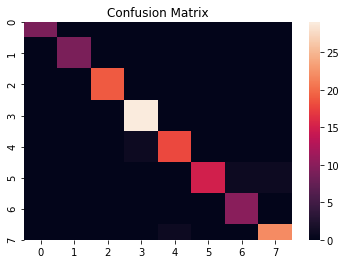

Using  resnet  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97328 
Recall = 0.97246 
F1 - Score = 0.97210



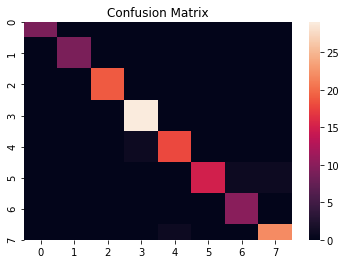

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97488 
Recall = 0.97246 
F1 - Score = 0.97276



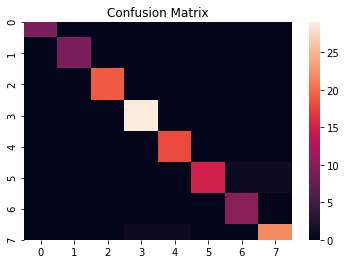

In [238]:
output_metrics_CFW_KNN = []
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 205, 'CFW', 'pca', None, neighbours = 7))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 7,  'CFW', 'lda', None, neighbours = 7))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 7, 'CFW', 'klda', None, neighbours = 7))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 205, 'CFW', 'kpca', None, neighbours = 7))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 205, 'CFW', 'vgg', neighbours = 7))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 205, 'CFW', 'vgg', 'pca', neighbours = 7))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 7, 'CFW', 'vgg', 'lda', neighbours = 7))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet', neighbours = 7))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet', 'pca', neighbours = 7))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 7, 'CFW', 'resnet', 'lda', neighbours = 7))

In [239]:
print('Using 7NN')
projections_CFW = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_CFW = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_CFW_KNN = pd.DataFrame(data = np.asarray(output_metrics_CFW_KNN), index = projections_CFW, columns = columns_CFW)
print(df_CFW_KNN)

Using 7NN
            Dimension   Accuracy      Error  Precision    Recall  F1 score
PCA             205.0  33.333333  66.666667   0.388205  0.341035  0.314059
LDA               7.0  31.111111  68.888889   0.313624  0.294482  0.292665
KLDA              7.0  20.000000  80.000000   0.075557  0.144079  0.077888
KPCA            205.0  32.592593  67.407407   0.424442  0.334456  0.312065
VGG            4096.0  68.148148  31.851852   0.673355  0.647482  0.648618
VGG+PCA         205.0  68.148148  31.851852   0.673355  0.647482  0.648618
VGG+LDA           7.0  63.703704  36.296296   0.567677  0.569094  0.565641
ResNet         2048.0  97.037037   2.962963   0.973280  0.972456  0.972103
ResNet+PCA      205.0  97.037037   2.962963   0.973280  0.972456  0.972103
ResNet+LDA        7.0  97.037037   2.962963   0.974877  0.972456  0.972759


Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.33333 
Precision = 0.38863 
Recall = 0.34104 
F1 - Score = 0.31456



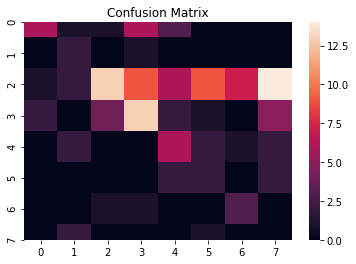

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.31111 
Precision = 0.31362 
Recall = 0.29448 
F1 - Score = 0.29267



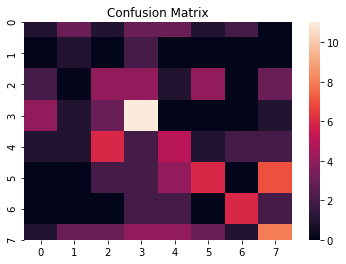

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.20000 
Precision = 0.07556 
Recall = 0.14408 
F1 - Score = 0.07789



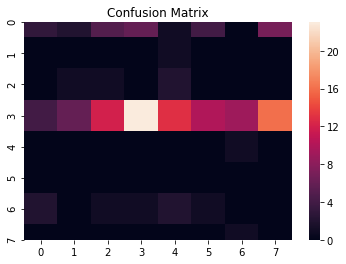

Projected using  kpca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.32593 
Precision = 0.42444 
Recall = 0.33446 
F1 - Score = 0.31206



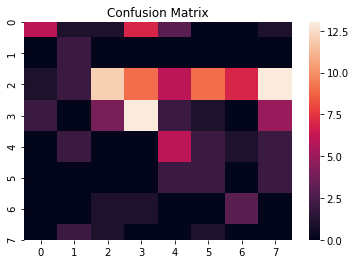

Using  vgg  Only
Dimension =  (537, 4096)
Using  CFW  dataset
Validation Accuracy = 0.68148 
Precision = 0.67335 
Recall = 0.64748 
F1 - Score = 0.64862



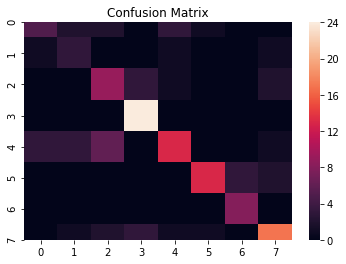

Using  vgg  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.68148 
Precision = 0.67335 
Recall = 0.64748 
F1 - Score = 0.64862



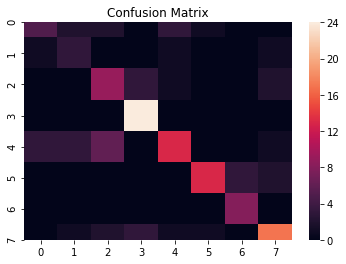

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.63704 
Precision = 0.56768 
Recall = 0.56909 
F1 - Score = 0.56564



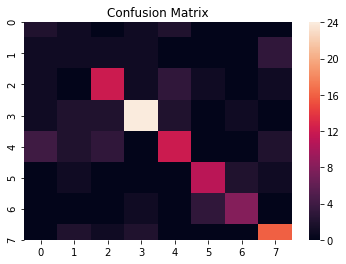

Using  resnet  Only
Dimension =  (537, 2048)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97328 
Recall = 0.97246 
F1 - Score = 0.97210



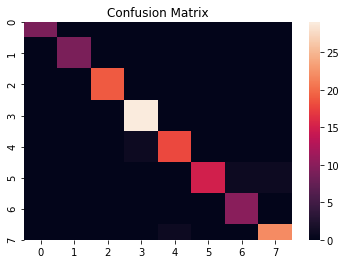

Using  resnet  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97328 
Recall = 0.97246 
F1 - Score = 0.97210



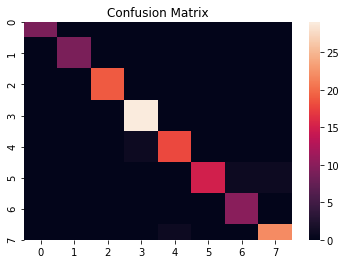

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 7)
Using  CFW  dataset
Validation Accuracy = 0.97037 
Precision = 0.97488 
Recall = 0.97246 
F1 - Score = 0.97276



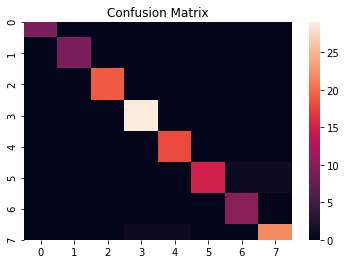

In [240]:
output_metrics_CFW_KNN = []
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 205, 'CFW', 'pca', None))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 7,  'CFW', 'lda', None))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 7, 'CFW', 'klda', None))
output_metrics_CFW_KNN.append(drive_KNN(X_CFW, y_CFW, 205, 'CFW', 'kpca', None))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 205, 'CFW', 'vgg'))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 205, 'CFW', 'vgg', 'pca'))
output_metrics_CFW_KNN.append(drive_KNN(get_vgg_features(dirpath[1]), y_CFW, 7, 'CFW', 'vgg', 'lda'))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet'))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 205, 'CFW', 'resnet', 'pca'))
output_metrics_CFW_KNN.append(drive_KNN(get_resnet_features(dirpath[1]), y_CFW, 7, 'CFW', 'resnet', 'lda'))

In [241]:
projections_CFW = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_CFW = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_CFW_KNN = pd.DataFrame(data = np.asarray(output_metrics_CFW_KNN), index = projections_CFW, columns = columns_CFW)
print(df_CFW_KNN)

            Dimension   Accuracy      Error  Precision    Recall  F1 score
PCA             205.0  33.333333  66.666667   0.388634  0.341035  0.314561
LDA               7.0  31.111111  68.888889   0.313624  0.294482  0.292665
KLDA              7.0  20.000000  80.000000   0.075557  0.144079  0.077888
KPCA            205.0  32.592593  67.407407   0.424442  0.334456  0.312065
VGG            4096.0  68.148148  31.851852   0.673355  0.647482  0.648618
VGG+PCA         205.0  68.148148  31.851852   0.673355  0.647482  0.648618
VGG+LDA           7.0  63.703704  36.296296   0.567677  0.569094  0.565641
ResNet         2048.0  97.037037   2.962963   0.973280  0.972456  0.972103
ResNet+PCA      205.0  97.037037   2.962963   0.973280  0.972456  0.972103
ResNet+LDA        7.0  97.037037   2.962963   0.974877  0.972456  0.972759


Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.72727 
Precision = 0.71905 
Recall = 0.73810 
F1 - Score = 0.67585



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


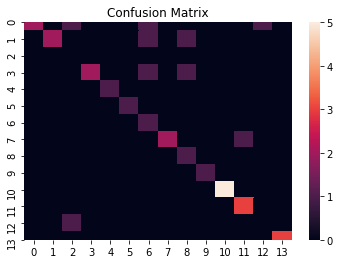

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.93939 
Precision = 0.94048 
Recall = 0.95833 
F1 - Score = 0.93741



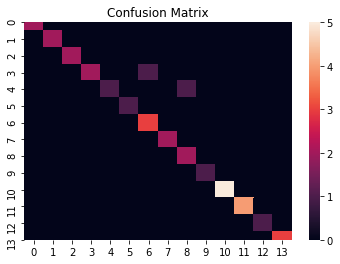

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.03030 
Precision = 0.00216 
Recall = 0.07143 
F1 - Score = 0.00420



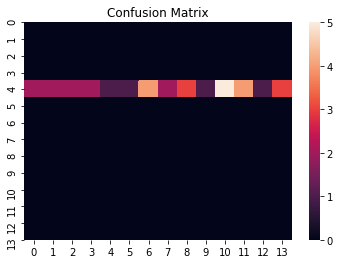

Projected using  kpca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.72727 
Precision = 0.71905 
Recall = 0.73810 
F1 - Score = 0.67585



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


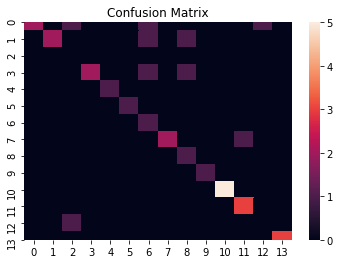

Using  vgg  Only
Dimension =  (132, 4096)
Using  Yale  dataset
Validation Accuracy = 0.51515 
Precision = 0.41333 
Recall = 0.49444 
F1 - Score = 0.42965



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


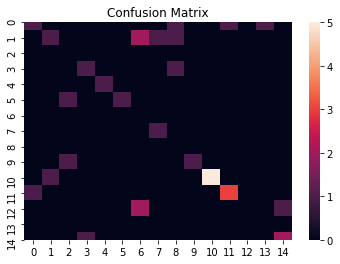

Using  vgg  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset


/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Validation Accuracy = 0.51515 
Precision = 0.41333 
Recall = 0.49444 
F1 - Score = 0.42965



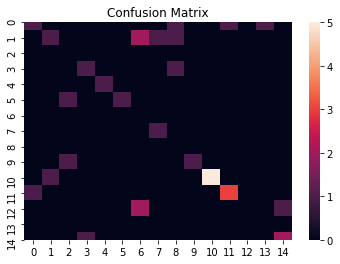

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/s

Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.54545 
Precision = 0.46222 
Recall = 0.51667 
F1 - Score = 0.46476



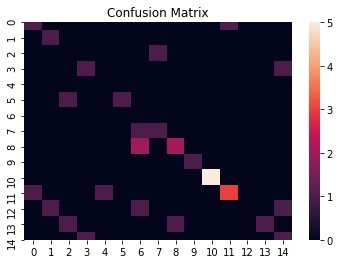

Using  resnet  Only
Dimension =  (132, 2048)
Using  Yale  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



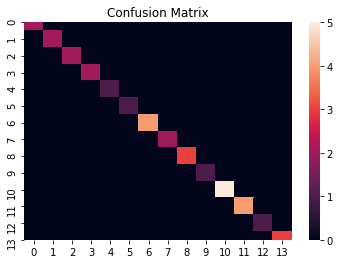

Using  resnet  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



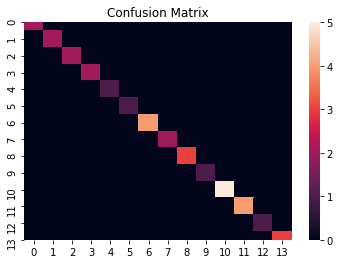

Using  resnet  first
Projected using  lda 

Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.96970 
Precision = 0.96429 
Recall = 0.96429 
F1 - Score = 0.95238



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


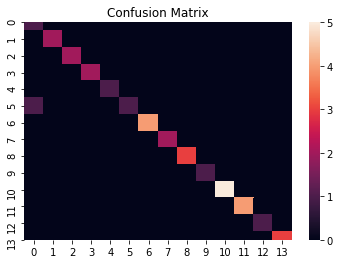

In [242]:
output_metrics_Yale_KNN = []
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 34, 'Yale', 'pca', None, neighbours = 3))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 14,  'Yale', 'lda', None, neighbours = 3))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 14, 'Yale', 'klda', None, neighbours = 3))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 34, 'Yale', 'kpca', None, neighbours = 3))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg', neighbours = 3))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg', 'pca', neighbours = 3))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 14, 'Yale', 'vgg', 'lda', neighbours = 3))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet', neighbours = 3))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet', 'pca', neighbours = 3))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 14, 'Yale', 'resnet', 'lda', neighbours = 3))

In [243]:
print('Using 3NN')
projections_Yale = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_Yale = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_Yale_KNN = pd.DataFrame(data = np.asarray(output_metrics_Yale_KNN), index = projections_Yale, columns = columns_Yale)
print(df_Yale_KNN)

Using 3NN
            Dimension    Accuracy      Error  Precision    Recall  F1 score
PCA              34.0   72.727273  27.272727   0.719048  0.738095  0.675850
LDA              14.0   93.939394   6.060606   0.940476  0.958333  0.937415
KLDA             14.0    3.030303  96.969697   0.002165  0.071429  0.004202
KPCA             34.0   72.727273  27.272727   0.719048  0.738095  0.675850
VGG            4096.0   51.515152  48.484848   0.413333  0.494444  0.429654
VGG+PCA          34.0   51.515152  48.484848   0.413333  0.494444  0.429654
VGG+LDA          14.0   54.545455  45.454545   0.462222  0.516667  0.464762
ResNet         2048.0  100.000000   0.000000   1.000000  1.000000  1.000000
ResNet+PCA       34.0  100.000000   0.000000   1.000000  1.000000  1.000000
ResNet+LDA       14.0   96.969697   3.030303   0.964286  0.964286  0.952381


Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.72727 
Precision = 0.71905 
Recall = 0.73810 
F1 - Score = 0.67585



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


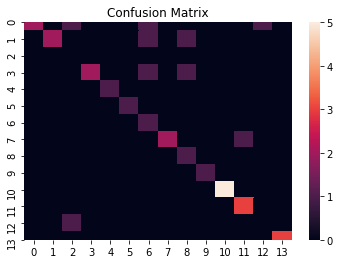

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.93939 
Precision = 0.94048 
Recall = 0.95833 
F1 - Score = 0.93741



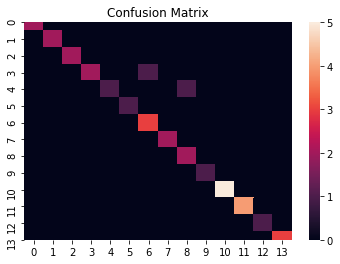

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.03030 
Precision = 0.00216 
Recall = 0.07143 
F1 - Score = 0.00420



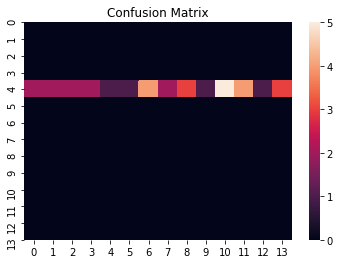

Projected using  kpca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.72727 
Precision = 0.71905 
Recall = 0.73810 
F1 - Score = 0.67585



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


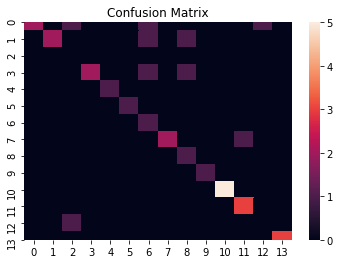

Using  vgg  Only
Dimension =  (132, 4096)
Using  Yale  dataset
Validation Accuracy = 0.51515 
Precision = 0.41333 
Recall = 0.49444 
F1 - Score = 0.42965



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


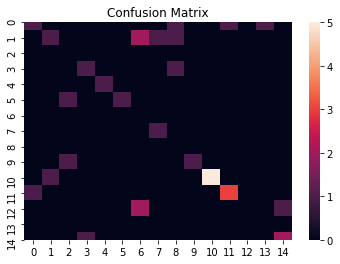

Using  vgg  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.51515 
Precision = 0.41333 
Recall = 0.49444 
F1 - Score = 0.42965



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


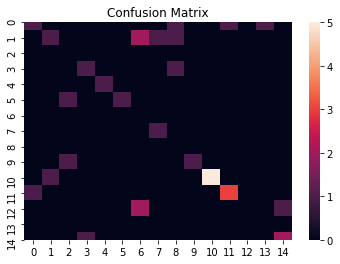

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/s

Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.54545 
Precision = 0.46222 
Recall = 0.51667 
F1 - Score = 0.46476



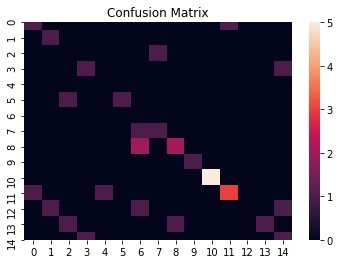

Using  resnet  Only
Dimension =  (132, 2048)
Using  Yale  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



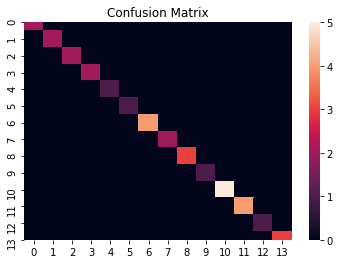

Using  resnet  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



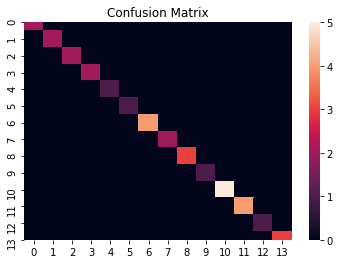

Using  resnet  first
Projected using  lda 

Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.96970 
Precision = 0.96429 
Recall = 0.96429 
F1 - Score = 0.95238



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


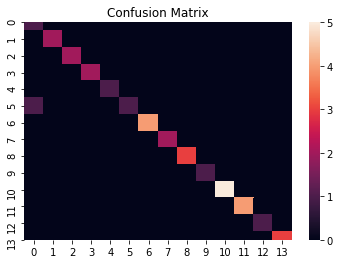

In [244]:
output_metrics_Yale_KNN = []
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 34, 'Yale', 'pca', None, neighbours = 5))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 14,  'Yale', 'lda', None, neighbours = 5))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 14, 'Yale', 'klda', None, neighbours = 5))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 34, 'Yale', 'kpca', None, neighbours = 5))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg', neighbours = 5))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg', 'pca', neighbours = 5))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 14, 'Yale', 'vgg', 'lda', neighbours = 5))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet', neighbours = 5))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet', 'pca', neighbours = 5))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 14, 'Yale', 'resnet', 'lda', neighbours = 5))

In [245]:
print('Using 5NN')
projections_Yale = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_Yale = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_Yale_KNN = pd.DataFrame(data = np.asarray(output_metrics_Yale_KNN), index = projections_Yale, columns = columns_Yale)
print(df_Yale_KNN)

Using 5NN
            Dimension    Accuracy      Error  Precision    Recall  F1 score
PCA              34.0   72.727273  27.272727   0.719048  0.738095  0.675850
LDA              14.0   93.939394   6.060606   0.940476  0.958333  0.937415
KLDA             14.0    3.030303  96.969697   0.002165  0.071429  0.004202
KPCA             34.0   72.727273  27.272727   0.719048  0.738095  0.675850
VGG            4096.0   51.515152  48.484848   0.413333  0.494444  0.429654
VGG+PCA          34.0   51.515152  48.484848   0.413333  0.494444  0.429654
VGG+LDA          14.0   54.545455  45.454545   0.462222  0.516667  0.464762
ResNet         2048.0  100.000000   0.000000   1.000000  1.000000  1.000000
ResNet+PCA       34.0  100.000000   0.000000   1.000000  1.000000  1.000000
ResNet+LDA       14.0   96.969697   3.030303   0.964286  0.964286  0.952381


Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.72727 
Precision = 0.71905 
Recall = 0.73810 
F1 - Score = 0.67585



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


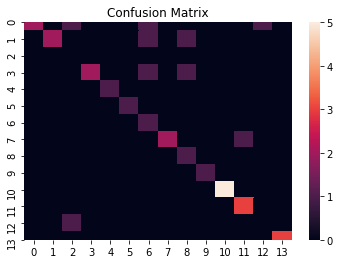

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.93939 
Precision = 0.94048 
Recall = 0.95833 
F1 - Score = 0.93741



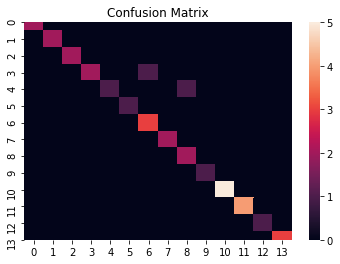

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.03030 
Precision = 0.00216 
Recall = 0.07143 
F1 - Score = 0.00420



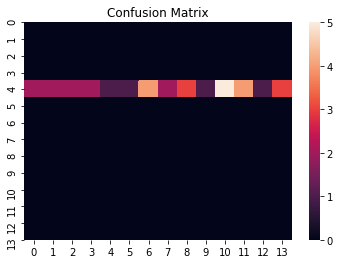

Projected using  kpca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.72727 
Precision = 0.71905 
Recall = 0.73810 
F1 - Score = 0.67585



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


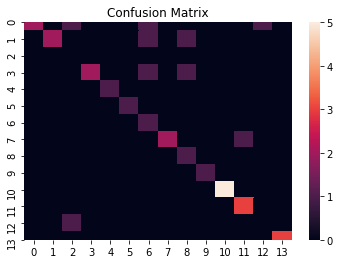

Using  vgg  Only
Dimension =  (132, 4096)
Using  Yale  dataset
Validation Accuracy = 0.51515 
Precision = 0.41333 
Recall = 0.49444 
F1 - Score = 0.42965



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


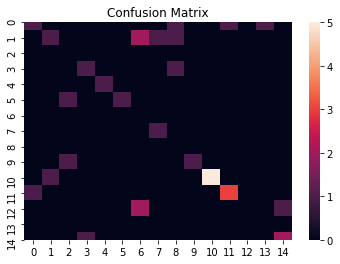

Using  vgg  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.51515 
Precision = 0.41333 
Recall = 0.49444 
F1 - Score = 0.42965



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


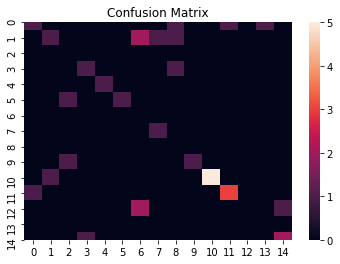

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/s

Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.54545 
Precision = 0.46222 
Recall = 0.51667 
F1 - Score = 0.46476



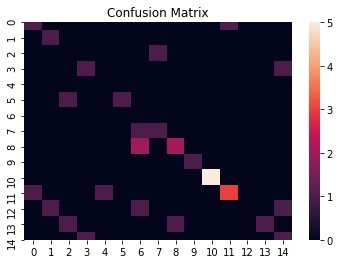

Using  resnet  Only
Dimension =  (132, 2048)
Using  Yale  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



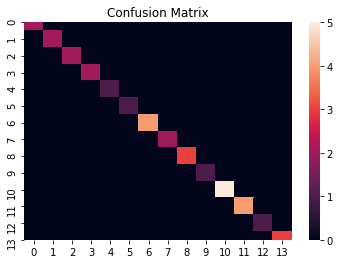

Using  resnet  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



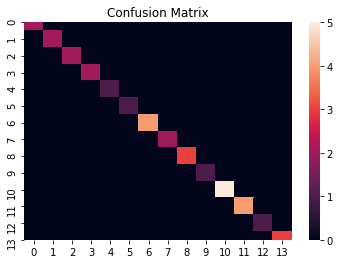

Using  resnet  first
Projected using  lda 

Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.96970 
Precision = 0.96429 
Recall = 0.96429 
F1 - Score = 0.95238



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


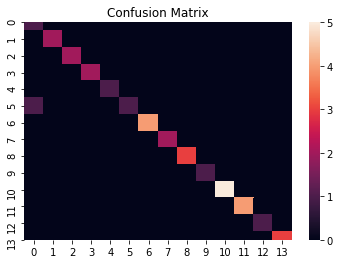

In [246]:
output_metrics_Yale_KNN = []
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 34, 'Yale', 'pca', None, neighbours = 7))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 14,  'Yale', 'lda', None, neighbours = 7))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 14, 'Yale', 'klda', None, neighbours = 7))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 34, 'Yale', 'kpca', None, neighbours = 7))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg', neighbours = 7))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg', 'pca', neighbours = 7))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 14, 'Yale', 'vgg', 'lda', neighbours = 7))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet', neighbours = 7))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet', 'pca', neighbours = 7))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 14, 'Yale', 'resnet', 'lda', neighbours = 7))

In [247]:
print('Using 7NN')
projections_Yale = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_Yale = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_Yale_KNN = pd.DataFrame(data = np.asarray(output_metrics_Yale_KNN), index = projections_Yale, columns = columns_Yale)
print(df_Yale_KNN)

Using 7NN
            Dimension    Accuracy      Error  Precision    Recall  F1 score
PCA              34.0   72.727273  27.272727   0.719048  0.738095  0.675850
LDA              14.0   93.939394   6.060606   0.940476  0.958333  0.937415
KLDA             14.0    3.030303  96.969697   0.002165  0.071429  0.004202
KPCA             34.0   72.727273  27.272727   0.719048  0.738095  0.675850
VGG            4096.0   51.515152  48.484848   0.413333  0.494444  0.429654
VGG+PCA          34.0   51.515152  48.484848   0.413333  0.494444  0.429654
VGG+LDA          14.0   54.545455  45.454545   0.462222  0.516667  0.464762
ResNet         2048.0  100.000000   0.000000   1.000000  1.000000  1.000000
ResNet+PCA       34.0  100.000000   0.000000   1.000000  1.000000  1.000000
ResNet+LDA       14.0   96.969697   3.030303   0.964286  0.964286  0.952381


Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.72727 
Precision = 0.71905 
Recall = 0.73810 
F1 - Score = 0.67585



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


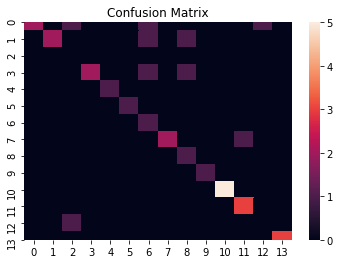

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.93939 
Precision = 0.94048 
Recall = 0.95833 
F1 - Score = 0.93741



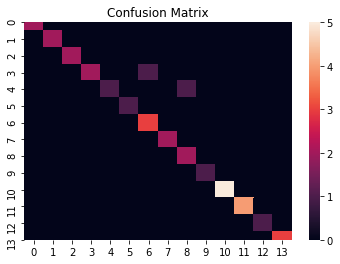

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.03030 
Precision = 0.00216 
Recall = 0.07143 
F1 - Score = 0.00420



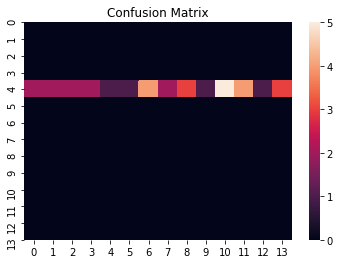

Projected using  kpca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.72727 
Precision = 0.71905 
Recall = 0.73810 
F1 - Score = 0.67585



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


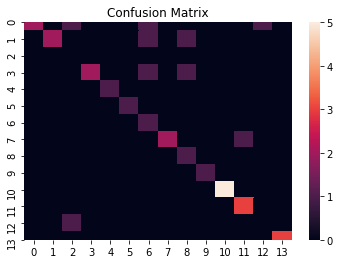

Using  vgg  Only
Dimension =  (132, 4096)
Using  Yale  dataset
Validation Accuracy = 0.51515 
Precision = 0.41333 
Recall = 0.49444 
F1 - Score = 0.42965



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


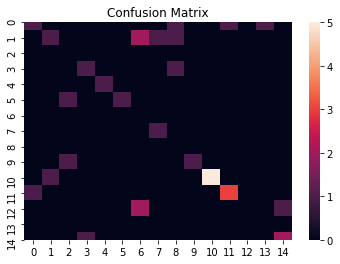

Using  vgg  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 0.51515 
Precision = 0.41333 
Recall = 0.49444 
F1 - Score = 0.42965



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


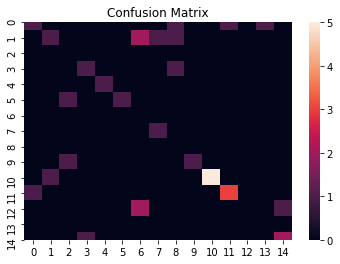

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/s

Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.54545 
Precision = 0.46222 
Recall = 0.51667 
F1 - Score = 0.46476



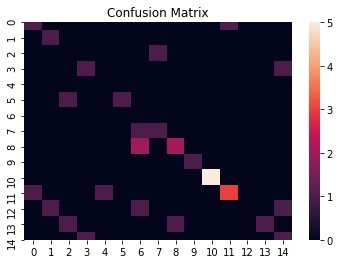

Using  resnet  Only
Dimension =  (132, 2048)
Using  Yale  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



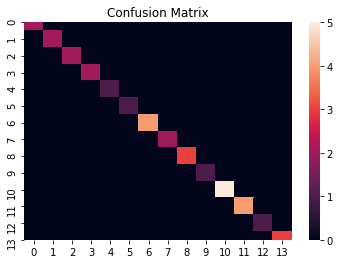

Using  resnet  first
Projected using  pca 

Dimension =  (132, 34)
Using  Yale  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



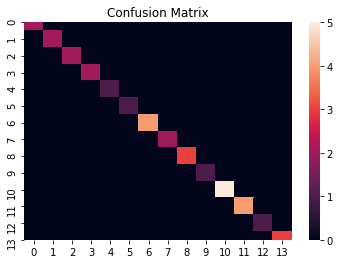

Using  resnet  first
Projected using  lda 

Dimension =  (132, 14)
Using  Yale  dataset
Validation Accuracy = 0.96970 
Precision = 0.96429 
Recall = 0.96429 
F1 - Score = 0.95238



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


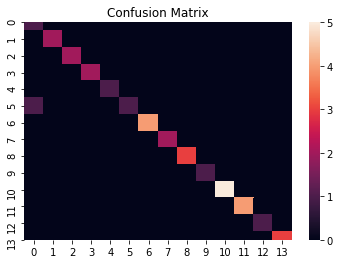

In [248]:
output_metrics_Yale_KNN = []
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 34, 'Yale', 'pca', None))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 14,  'Yale', 'lda', None))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 14, 'Yale', 'klda', None))
output_metrics_Yale_KNN.append(drive_KNN(X_Yale, y_Yale, 34, 'Yale', 'kpca', None))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg'))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 34, 'Yale', 'vgg', 'pca'))
output_metrics_Yale_KNN.append(drive_KNN(get_vgg_features(dirpath[2]), y_Yale, 14, 'Yale', 'vgg', 'lda'))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet'))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 34, 'Yale', 'resnet', 'pca'))
output_metrics_Yale_KNN.append(drive_KNN(get_resnet_features(dirpath[2]), y_Yale, 14, 'Yale', 'resnet', 'lda'))

In [249]:
print('Using unspecified k for KNN')
projections_Yale = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns_Yale = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_Yale_KNN = pd.DataFrame(data = np.asarray(output_metrics_Yale_KNN), index = projections_Yale, columns = columns_Yale)
print(df_Yale_KNN)

Using unspecified k for KNN
            Dimension    Accuracy      Error  Precision    Recall  F1 score
PCA              34.0   72.727273  27.272727   0.719048  0.738095  0.675850
LDA              14.0   93.939394   6.060606   0.940476  0.958333  0.937415
KLDA             14.0    3.030303  96.969697   0.002165  0.071429  0.004202
KPCA             34.0   72.727273  27.272727   0.719048  0.738095  0.675850
VGG            4096.0   51.515152  48.484848   0.413333  0.494444  0.429654
VGG+PCA          34.0   51.515152  48.484848   0.413333  0.494444  0.429654
VGG+LDA          14.0   54.545455  45.454545   0.462222  0.516667  0.464762
ResNet         2048.0  100.000000   0.000000   1.000000  1.000000  1.000000
ResNet+PCA       34.0  100.000000   0.000000   1.000000  1.000000  1.000000
ResNet+LDA       14.0   96.969697   3.030303   0.964286  0.964286  0.952381


In [250]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
print('Using Unspecified value of K for KNN')
print(' ')
print('Comparison of different features on IMFDB Dataset')
print(df_IMFDB_KNN)
print(' ')
print('Comparison of different features on CFW Dataset')
print(df_CFW_KNN)
print(' ')
print('Comparison of different features on Yale Dataset')
print(df_Yale_KNN)
print(' ')

Using Unspecified value of K for KNN
 
Comparison of different features on IMFDB Dataset
            Dimension  Accuracy  Error  Precision    Recall  F1 score
PCA              69.0     60.00  40.00   0.677951  0.655064  0.594332
LDA               7.0     80.00  20.00   0.799693  0.817651  0.789083
KLDA              7.0      3.75  96.25   0.009615  0.053571  0.016304
KPCA             69.0     60.00  40.00   0.718254  0.655064  0.597127
VGG            4096.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+PCA          69.0     88.75  11.25   0.879132  0.873836  0.874352
VGG+LDA           7.0     72.50  27.50   0.722727  0.734419  0.720255
ResNet         2048.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+PCA       69.0     93.75   6.25   0.938636  0.939048  0.935293
ResNet+LDA        7.0     93.75   6.25   0.944643  0.939048  0.940331
 
Comparison of different features on CFW Dataset
            Dimension   Accuracy      Error  Precision    Recall  F1 score
PCA             

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

### Perform Gender classification on IIIT-CFW and IMFDB dataset

- Gender based classification
- Use `0` for `males` and `1` for `females`

In [251]:
# Load data
cfw_gender_dict = {'Amitabhbachan': 0,
    'AamirKhan': 0,
    'DwayneJohnson': 0,
    'AishwaryaRai': 1,
    'BarackObama': 0,
    'NarendraModi': 0,
    'ManmohanSingh': 0,
    'VladimirPutin': 0}

imfdb_gender_dict = {'MadhuriDixit': 1,
     'Kajol': 1,
     'SharukhKhan': 0,
     'ShilpaShetty': 1,
     'AmitabhBachan': 0,
     'KatrinaKaif': 1,
     'AkshayKumar': 0,
     'Amir': 0}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_gender_dict

    elif "IMFDB" in dir_path:
        label_dict = imfdb_gender_dict
    
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()
    
# Loading the dataset
# eg.
dirpath = ['./dataset/IMFDB/', './dataset/IIIT-CFW/', './dataset/Yale_face_database/']

X_gender_IMFDB,y_gender_IMFDB = load_data(dirpath[0])
X_gender_CFW,y_gender_CFW = load_data(dirpath[1])
N_IMFDB,H_IMFDB,W_IMFDB = X_gender_IMFDB.shape[0:3]
C_IMFDB = 1 if opt['is_grayscale'] else X_gender_IMFDB.shape[3]
N_CFW,H_CFW,W_CFW = X_gender_CFW.shape[0:3]
C_CFW = 1 if opt['is_grayscale'] else X_gender_CFW.shape[3]

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)


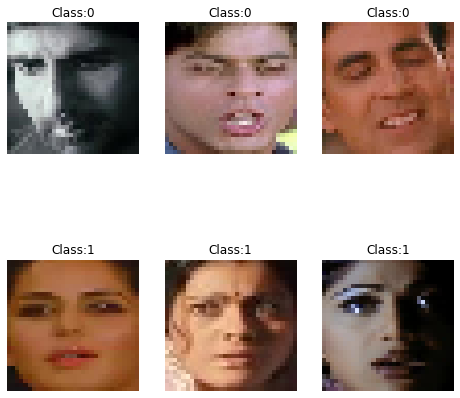

In [252]:
# Show sample images
ind = np.random.randint(0,y_gender_IMFDB.shape[0],6)
disply_images(X_gender_IMFDB[ind,...],y_gender_IMFDB[ind], row=2,col=3)

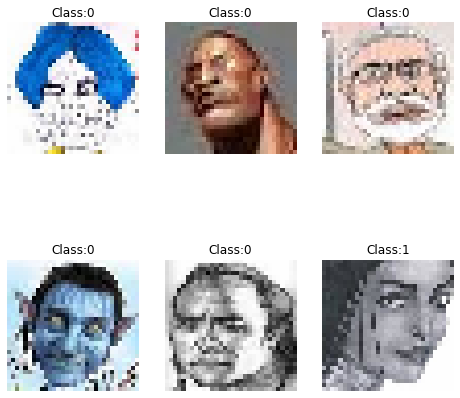

In [253]:
# Show sample images
ind = np.random.randint(0,y_gender_CFW.shape[0],6)
disply_images(X_gender_CFW[ind,...],y_gender_CFW[ind], row=2,col=3)

In [254]:
# Flatten to apply PCA/LDA
X_gender_IMFDB = X_gender_IMFDB.reshape((N_IMFDB,H_IMFDB*W_IMFDB*C_IMFDB))
X_gender_CFW = X_gender_CFW.reshape((N_CFW,H_CFW*W_CFW*C_CFW))

#### Define your features

**We will search for the best features by running the features on an MLP classifier with hidden layer of size (1000,1000) and noting the accuracy for the following features :-**

- PCA
- LDA
- KLDA (rbf)
- KPCA (rbf)
- VGG
- VGG+PCA
- VGG+LDA
- ResNet
- ResNet+PCA
- ResNet+LDA

In [256]:
# Create your classifier
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self):
        super().__init__()
        self.clf = MLPClassifier(hidden_layer_sizes=(1000,1000), max_iter=1000, solver = 'adam', activation='relu')
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self, X):
        """
            Given an input X classify it into appropriate class. 
        """
        
#         self.clf.fit(X, y)
        prediction = self.clf.predict(X)
        return prediction
        
    def confusion_mat(self, pred, y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        return confusion_matrix(pred, y)
        
    def train(self, X_train, y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.clf.fit(X_train, y_train)
        
    def validate(self,X_train, y_train, X_validate, y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        self.train(X_train, y_train)
        pred_val = self.classify(X_validate)
        # Create a confusion matrix
        conf_mat = self.confusion_mat(pred_val, y_validate)
        # Calculate Validation accuracy 
        val_acc = self.clf.score(X_validate, y_validate)
        # Calculate precision and recall 
        prec = precision_score(y_validate, pred_val, average = 'macro')
        rec = recall_score(y_validate, pred_val, average = 'macro')
        # Calculate F1-score
        f1 = f1_score(y_validate, pred_val, average = 'macro')
    
        return conf_mat, val_acc, prec, rec, f1
# Validate your classifier

In [257]:
# Create a train and validation split to train your classifier
def train_val_split(data, labels, test_size = 0.2, random_state = 42):
    data_train, data_val, labels_train, labels_val = train_test_split(data, labels, test_size = test_size, random_state = random_state)
    
    return data_train, labels_train, data_val, labels_val

In [258]:
# Run classifier function

# Using raw input X
def show_stats(X_train, y_train, X_val, y_val, dataset, test_size = 0.2):
    print('Using ', dataset, ' dataset')
    clf = Classifier()
    clf.train(X_train, y_train)
    conf_mat, val_acc, prec, rec, f1 = clf.validate(X_train, y_train, X_val, y_val)
    print('Validation Accuracy = %.5f \nPrecision = %.5f \nRecall = %.5f \nF1 - Score = %.5f\n'%(val_acc, prec, rec, f1))
    sn.heatmap(conf_mat)
    plt.title('Confusion Matrix')
    plt.show()
    return conf_mat, val_acc, prec, rec, f1

In [259]:
def drive(X, y, k, dataset, projection1, projection2 = None, test_size = 0.2):
    if projection2 is None and (projection1 is not 'vgg' and projection1 is not 'resnet'):
        X_train, y_train, X_val, y_val = train_val_split(X,y, test_size=test_size)
        X_train_proj, proj_model = project_images(X_train, y_train, k, projection1)
        X_val_proj = proj_model.transform(X_val)
        print('Dimension = ',X_train_proj.shape)
        dimension = X_train_proj.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
    elif projection2 is None and (projection1 is 'vgg' or projection1 is 'resnet'):
        print('Using ',projection1, ' Only')
        X_train, y_train, X_val, y_val = train_val_split(X,y, test_size=test_size)
        print('Dimension = ',X_train.shape)
        dimension = X_train.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats(X_train, y_train, X_val, y_val, dataset, 0.1)
    elif projection2 is not None and projection1 is 'vgg':
        print('Using ',projection1, ' first')
        X_train, y_train, X_val, y_val = train_val_split(X,y, test_size=test_size)
        X_train_proj, proj_model = project_images(X_train, y_train, k, projection2)
        X_val_proj = proj_model.transform(X_val)
        print('Dimension = ',X_train_proj.shape)
        dimension = X_train_proj.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
    elif projection2 is not None and projection1 is 'resnet':
        print('Using ',projection1, ' first')
        X_train, y_train, X_val, y_val = train_val_split(X,y, test_size=test_size)
        X_train_proj, proj_model = project_images(X_train, y_train, k, projection2)
        X_val_proj = proj_model.transform(X_val)
        print('Dimension = ',X_train_proj.shape)
        dimension = X_train_proj.shape[1]
        conf_mat, val_acc, prec, rec, f1 = show_stats(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
    return dimension, 100*val_acc, 100*(1-val_acc), prec, rec, f1

Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.92500 
Precision = 0.92677 
Recall = 0.92356 
F1 - Score = 0.92458



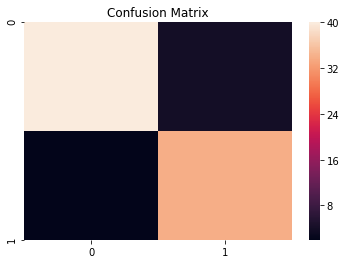

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 1)
Using  IMFDB  dataset
Validation Accuracy = 0.83750 
Precision = 0.84603 
Recall = 0.84148 
F1 - Score = 0.83727



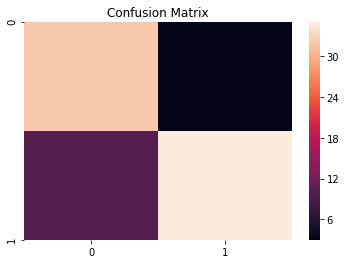

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 1)
Using  IMFDB  dataset
Validation Accuracy = 0.41250 
Precision = 0.41278 
Recall = 0.41917 
F1 - Score = 0.40497



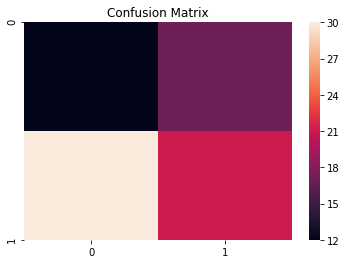

Projected using  kpca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.88750 
Precision = 0.89048 
Recall = 0.88534 
F1 - Score = 0.88663



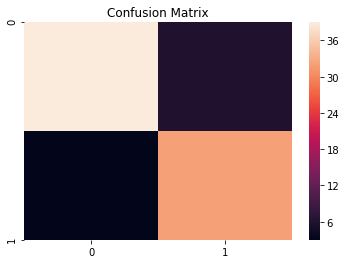

Using  vgg  Only
Dimension =  (320, 4096)
Using  IMFDB  dataset
Validation Accuracy = 0.95000 
Precision = 0.95000 
Recall = 0.95113 
F1 - Score = 0.94997



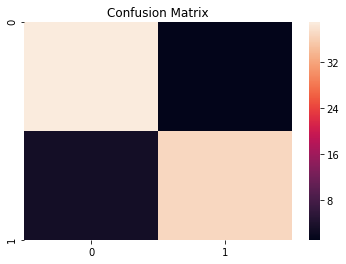

Using  vgg  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.97500 
Precision = 0.97494 
Recall = 0.97494 
F1 - Score = 0.97494



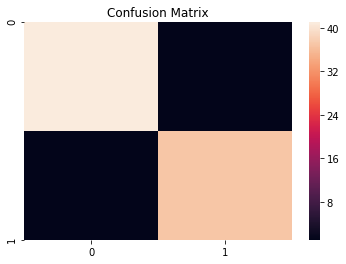

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 1)
Using  IMFDB  dataset
Validation Accuracy = 0.83750 
Precision = 0.83968 
Recall = 0.83521 
F1 - Score = 0.83625



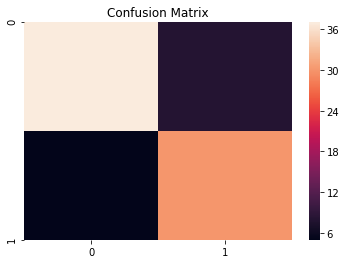

Using  resnet  Only
Dimension =  (320, 2048)
Using  IMFDB  dataset
Validation Accuracy = 0.98750 
Precision = 0.98718 
Recall = 0.98810 
F1 - Score = 0.98748



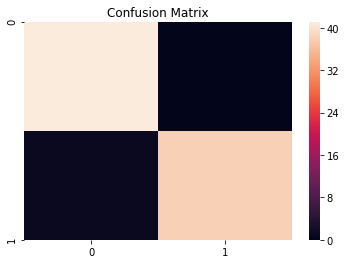

Using  resnet  first
Projected using  pca 

Dimension =  (320, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.98750 
Precision = 0.98718 
Recall = 0.98810 
F1 - Score = 0.98748



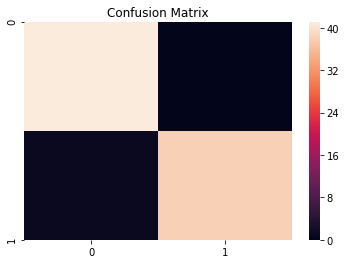

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (320, 1)
Using  IMFDB  dataset
Validation Accuracy = 0.98750 
Precision = 0.98837 
Recall = 0.98684 
F1 - Score = 0.98745



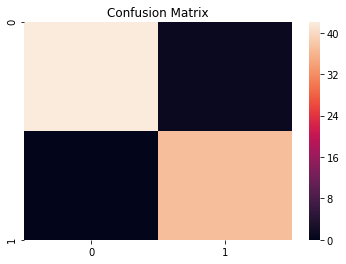

Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.86667 
Precision = 0.82095 
Recall = 0.77143 
F1 - Score = 0.79167



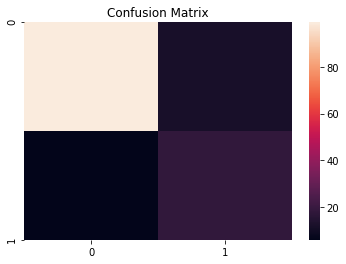

Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 1)
Using  CFW  dataset
Validation Accuracy = 0.71852 
Precision = 0.60702 
Recall = 0.61667 
F1 - Score = 0.61089



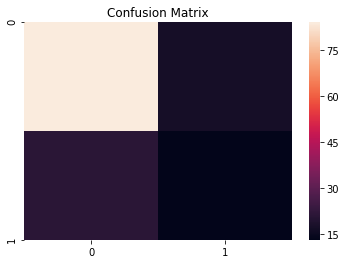

Projected using  klda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 1)
Using  CFW  dataset
Validation Accuracy = 0.32593 
Precision = 0.52414 
Recall = 0.51905 
F1 - Score = 0.32355



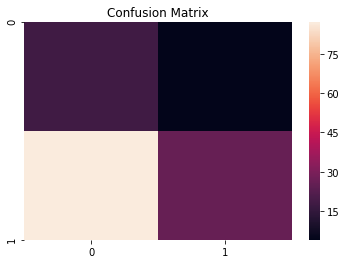

Projected using  kpca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.87407 
Precision = 0.84774 
Recall = 0.76429 
F1 - Score = 0.79452



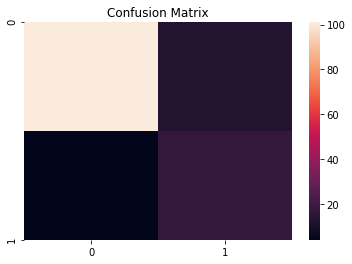

Using  vgg  Only
Dimension =  (537, 4096)
Using  CFW  dataset
Validation Accuracy = 0.96296 
Precision = 0.97727 
Recall = 0.91667 
F1 - Score = 0.94292



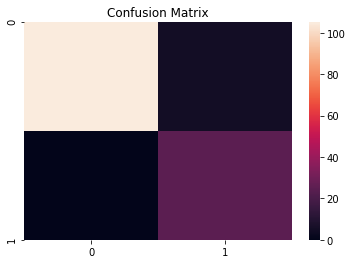

Using  vgg  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.96296 
Precision = 0.97727 
Recall = 0.91667 
F1 - Score = 0.94292



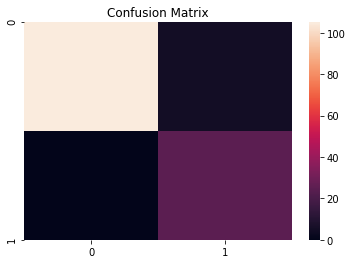

Using  vgg  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 1)
Using  CFW  dataset
Validation Accuracy = 0.88889 
Precision = 0.84157 
Recall = 0.83333 
F1 - Score = 0.83734



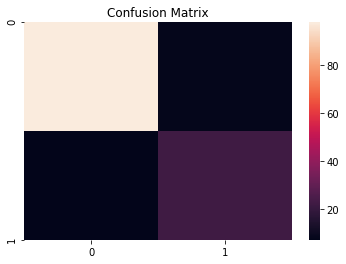

Using  resnet  Only
Dimension =  (537, 2048)
Using  CFW  dataset
Validation Accuracy = 0.99259 
Precision = 0.99528 
Recall = 0.98333 
F1 - Score = 0.98916



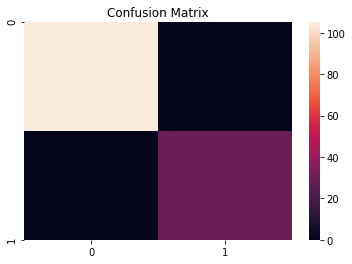

Using  resnet  first
Projected using  pca 

Dimension =  (537, 205)
Using  CFW  dataset
Validation Accuracy = 0.99259 
Precision = 0.99528 
Recall = 0.98333 
F1 - Score = 0.98916



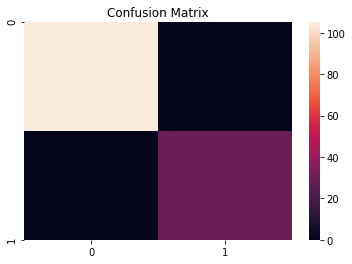

Using  resnet  first
Projected using  lda 



/home/soumyasis/.virtualenvs/cvit1/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Dimension =  (537, 1)
Using  CFW  dataset
Validation Accuracy = 0.99259 
Precision = 0.99528 
Recall = 0.98333 
F1 - Score = 0.98916



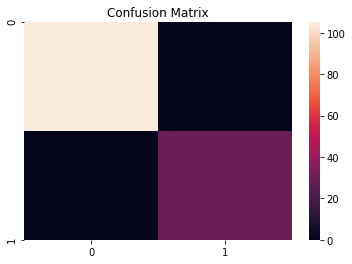

In [260]:
output_metrics_gender_IMFDB = []
output_metrics_gender_IMFDB.append(drive(X_gender_IMFDB, y_gender_IMFDB, 69, 'IMFDB', 'pca', None))
output_metrics_gender_IMFDB.append(drive(X_gender_IMFDB, y_gender_IMFDB, 1,  'IMFDB', 'lda', None))
output_metrics_gender_IMFDB.append(drive(X_gender_IMFDB, y_gender_IMFDB, 1, 'IMFDB', 'klda', None))
output_metrics_gender_IMFDB.append(drive(X_gender_IMFDB, y_gender_IMFDB, 69, 'IMFDB', 'kpca', None))
output_metrics_gender_IMFDB.append(drive(get_vgg_features(dirpath[0]), y_gender_IMFDB, 69, 'IMFDB', 'vgg'))
output_metrics_gender_IMFDB.append(drive(get_vgg_features(dirpath[0]), y_gender_IMFDB, 69, 'IMFDB', 'vgg', 'pca'))
output_metrics_gender_IMFDB.append(drive(get_vgg_features(dirpath[0]), y_gender_IMFDB, 1, 'IMFDB', 'vgg', 'lda'))
output_metrics_gender_IMFDB.append(drive(get_resnet_features(dirpath[0]), y_gender_IMFDB, 69, 'IMFDB', 'resnet'))
output_metrics_gender_IMFDB.append(drive(get_resnet_features(dirpath[0]), y_gender_IMFDB, 69, 'IMFDB', 'resnet', 'pca'))
output_metrics_gender_IMFDB.append(drive(get_resnet_features(dirpath[0]), y_gender_IMFDB, 1, 'IMFDB', 'resnet', 'lda'))

output_metrics_gender_CFW = []
output_metrics_gender_CFW.append(drive(X_gender_CFW, y_gender_CFW, 205, 'CFW', 'pca', None))
output_metrics_gender_CFW.append(drive(X_gender_CFW, y_gender_CFW, 1,  'CFW', 'lda', None))
output_metrics_gender_CFW.append(drive(X_gender_CFW, y_gender_CFW, 1, 'CFW', 'klda', None))
output_metrics_gender_CFW.append(drive(X_gender_CFW, y_gender_CFW, 205, 'CFW', 'kpca', None))
output_metrics_gender_CFW.append(drive(get_vgg_features(dirpath[1]), y_gender_CFW, 205, 'CFW', 'vgg'))
output_metrics_gender_CFW.append(drive(get_vgg_features(dirpath[1]), y_gender_CFW, 205, 'CFW', 'vgg', 'pca'))
output_metrics_gender_CFW.append(drive(get_vgg_features(dirpath[1]), y_gender_CFW, 1, 'CFW', 'vgg', 'lda'))
output_metrics_gender_CFW.append(drive(get_resnet_features(dirpath[1]), y_gender_CFW, 205, 'CFW', 'resnet'))
output_metrics_gender_CFW.append(drive(get_resnet_features(dirpath[1]), y_gender_CFW, 205, 'CFW', 'resnet', 'pca'))
output_metrics_gender_CFW.append(drive(get_resnet_features(dirpath[1]), y_gender_CFW, 1, 'CFW', 'resnet', 'lda'))


In [261]:
projections = (['PCA','LDA','KLDA','KPCA','VGG','VGG+PCA','VGG+LDA','ResNet','ResNet+PCA','ResNet+LDA'])
columns = (['Dimension','Accuracy', 'Error','Precision', 'Recall', 'F1 score'])
df_gender_IMFDB = pd.DataFrame(data = np.asarray(output_metrics_gender_IMFDB), index = projections, columns = columns)
df_gender_CFW = pd.DataFrame(data = np.asarray(output_metrics_gender_CFW), index = projections, columns = columns)
print('Comparison of different features on IMFDB Dataset')
print(df_gender_IMFDB)
print(' ')
print('Comparison of different features on CFW Dataset')
print(df_gender_CFW)
print(' ')

Comparison of different features on IMFDB Dataset
            Dimension  Accuracy  Error  Precision    Recall  F1 score
PCA              69.0     92.50   7.50   0.926768  0.923559  0.924576
LDA               1.0     83.75  16.25   0.846032  0.841479  0.837271
KLDA              1.0     41.25  58.75   0.412779  0.419173  0.404969
KPCA             69.0     88.75  11.25   0.890476  0.885338  0.886632
VGG            4096.0     95.00   5.00   0.950000  0.951128  0.949969
VGG+PCA          69.0     97.50   2.50   0.974937  0.974937  0.974937
VGG+LDA           1.0     83.75  16.25   0.839683  0.835213  0.836246
ResNet         2048.0     98.75   1.25   0.987179  0.988095  0.987482
ResNet+PCA       69.0     98.75   1.25   0.987179  0.988095  0.987482
ResNet+LDA        1.0     98.75   1.25   0.988372  0.986842  0.987451
 
Comparison of different features on CFW Dataset
            Dimension   Accuracy      Error  Precision    Recall  F1 score
PCA             205.0  86.666667  13.333333   0.820946 

In [262]:
kfolds = [4, 8, 12, 16]

def kfold_cross_validation(X, y, kfolds, proj, dataset, projection1, projection2 = None):
    output = []
    for k in kfolds:
        kfold = KFold(n_splits = k, random_state=42, shuffle = True)
        avg_acc, avg_err, avg_f1, cnt = 0,0,0,0
        for train_idx, val_idx in kfold.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            print('Shape of training = ',X_train.shape)
            X_train_proj, proj_model = project_images(X_train, y_train, proj, projection2)
            X_val_proj = proj_model.transform(X_val)
            print('Dimension = ',X_train_proj.shape)
            dimension = X_train_proj.shape[1]
            conf_mat, acc, prec, rec, f1 = show_stats(X_train_proj, y_train, X_val_proj, y_val, dataset, 0.1)
            avg_acc+=acc
            avg_err+=1-acc
            avg_f1+=f1
            cnt+=1
        avg_acc/=cnt
        avg_err/=cnt
        avg_f1/=cnt
        output.append([100*acc,100*(1-acc),f1])
        
    df = pd.DataFrame(data = np.asarray(output), index = kfolds, columns = ['Accuracy','Error', 'F1 score'])
#     print(df)    
    return df

Shape of training =  (300, 2048)
Projected using  pca 

Dimension =  (300, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.99000 
Precision = 0.98980 
Recall = 0.99038 
F1 - Score = 0.98999



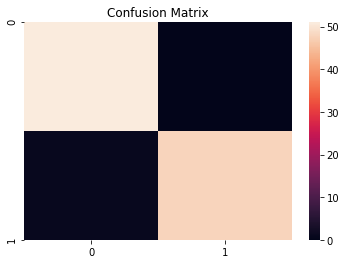

Shape of training =  (300, 2048)
Projected using  pca 

Dimension =  (300, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.97000 
Precision = 0.96900 
Recall = 0.97071 
F1 - Score = 0.96976



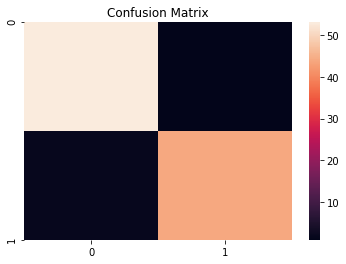

Shape of training =  (300, 2048)
Projected using  pca 

Dimension =  (300, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.98000 
Precision = 0.97947 
Recall = 0.97947 
F1 - Score = 0.97947



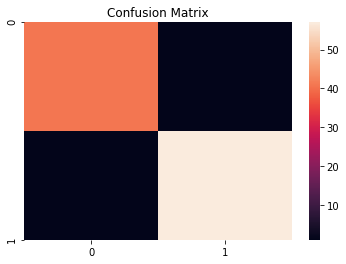

Shape of training =  (300, 2048)
Projected using  pca 

Dimension =  (300, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.97000 
Precision = 0.97222 
Recall = 0.96939 
F1 - Score = 0.96992



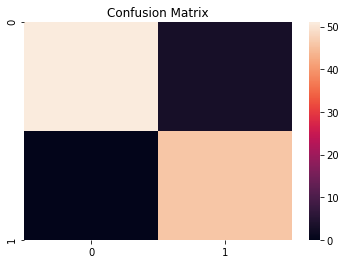

Shape of training =  (350, 2048)
Projected using  pca 

Dimension =  (350, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.98000 
Precision = 0.97917 
Recall = 0.98148 
F1 - Score = 0.97993



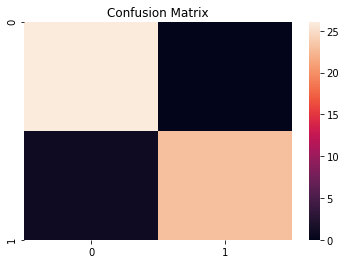

Shape of training =  (350, 2048)
Projected using  pca 

Dimension =  (350, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



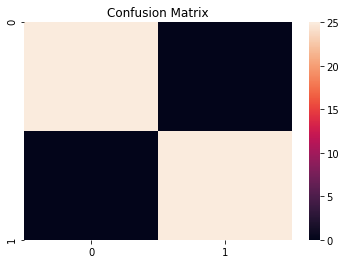

Shape of training =  (350, 2048)
Projected using  pca 

Dimension =  (350, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.94000 
Precision = 0.94122 
Recall = 0.93910 
F1 - Score = 0.93978



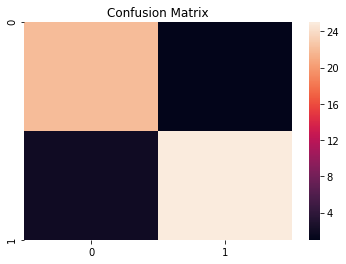

Shape of training =  (350, 2048)
Projected using  pca 

Dimension =  (350, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



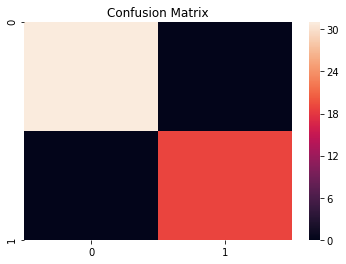

Shape of training =  (350, 2048)
Projected using  pca 

Dimension =  (350, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



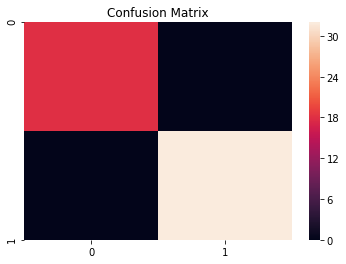

Shape of training =  (350, 2048)
Projected using  pca 

Dimension =  (350, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.96000 
Precision = 0.95994 
Recall = 0.95994 
F1 - Score = 0.95994



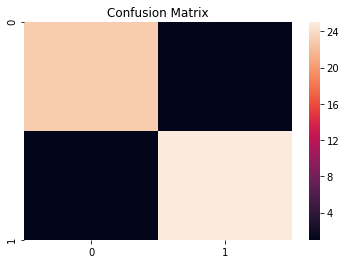

Shape of training =  (350, 2048)
Projected using  pca 

Dimension =  (350, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.98000 
Precision = 0.98077 
Recall = 0.98000 
F1 - Score = 0.97999



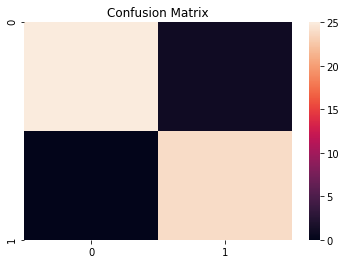

Shape of training =  (350, 2048)
Projected using  pca 

Dimension =  (350, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.98000 
Precision = 0.98148 
Recall = 0.97917 
F1 - Score = 0.97993



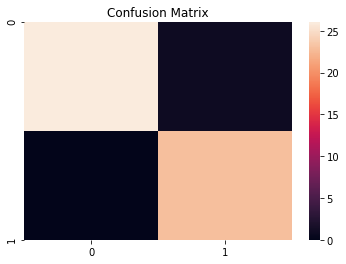

Shape of training =  (366, 2048)
Projected using  pca 

Dimension =  (366, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



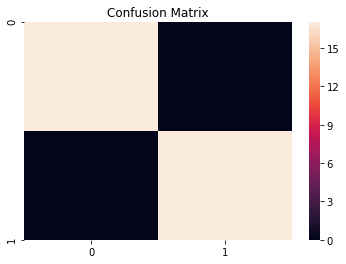

Shape of training =  (366, 2048)
Projected using  pca 

Dimension =  (366, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



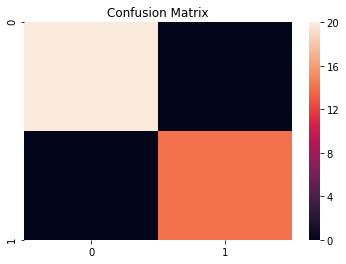

Shape of training =  (366, 2048)
Projected using  pca 

Dimension =  (366, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



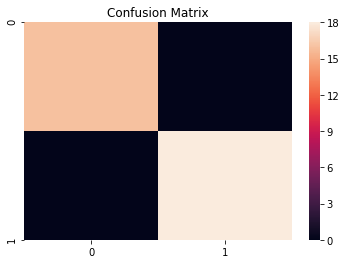

Shape of training =  (366, 2048)
Projected using  pca 

Dimension =  (366, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.91176 
Precision = 0.91176 
Recall = 0.91319 
F1 - Score = 0.91169



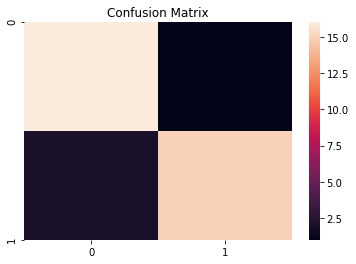

Shape of training =  (367, 2048)
Projected using  pca 

Dimension =  (367, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



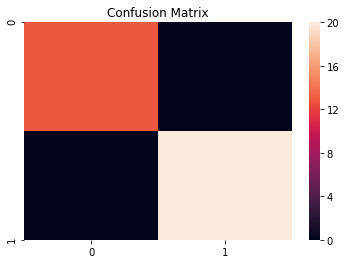

Shape of training =  (367, 2048)
Projected using  pca 

Dimension =  (367, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



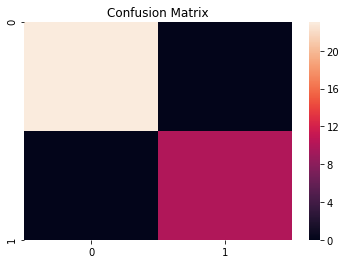

Shape of training =  (367, 2048)
Projected using  pca 

Dimension =  (367, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



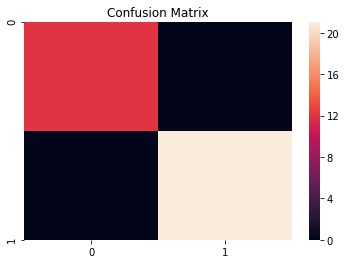

Shape of training =  (367, 2048)
Projected using  pca 

Dimension =  (367, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



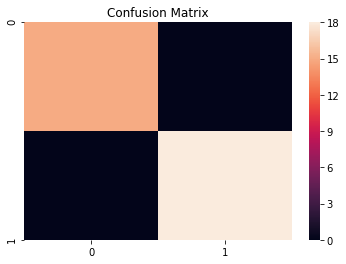

Shape of training =  (367, 2048)
Projected using  pca 

Dimension =  (367, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.93939 
Precision = 0.93889 
Recall = 0.93889 
F1 - Score = 0.93889



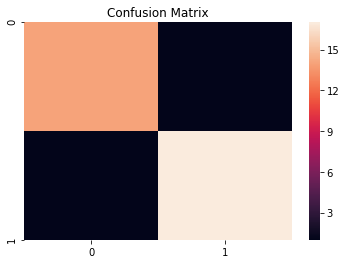

Shape of training =  (367, 2048)
Projected using  pca 

Dimension =  (367, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.96970 
Precision = 0.96667 
Recall = 0.97368 
F1 - Score = 0.96925



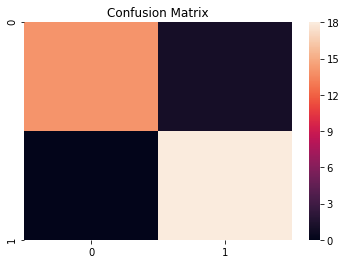

Shape of training =  (367, 2048)
Projected using  pca 

Dimension =  (367, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.96970 
Precision = 0.97500 
Recall = 0.96429 
F1 - Score = 0.96866



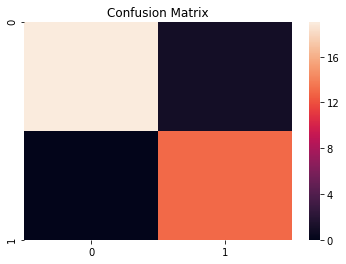

Shape of training =  (367, 2048)
Projected using  pca 

Dimension =  (367, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



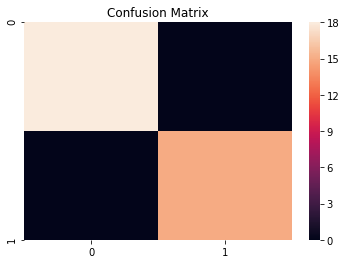

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



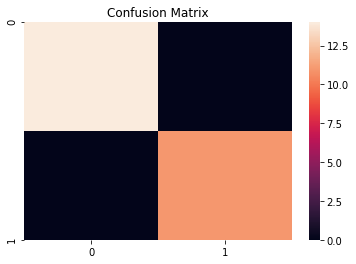

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



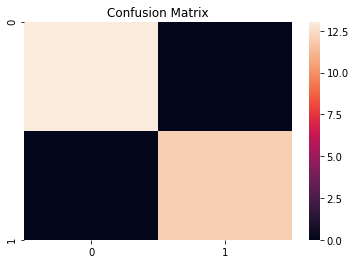

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



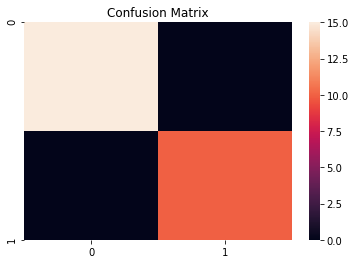

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



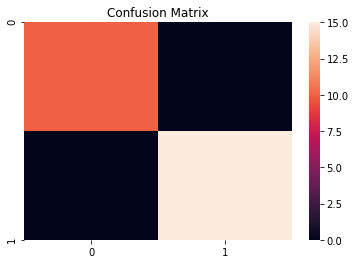

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.96000 
Precision = 0.95455 
Recall = 0.96667 
F1 - Score = 0.95895



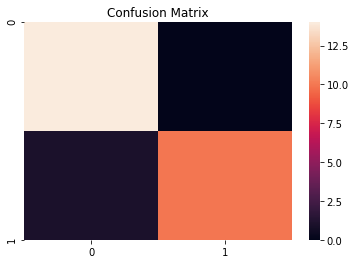

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.96000 
Precision = 0.95000 
Recall = 0.96875 
F1 - Score = 0.95756



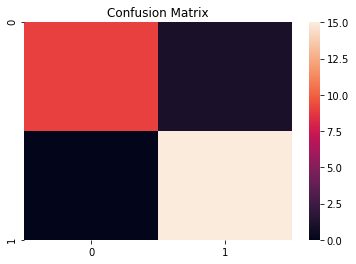

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



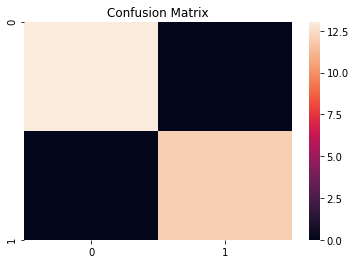

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



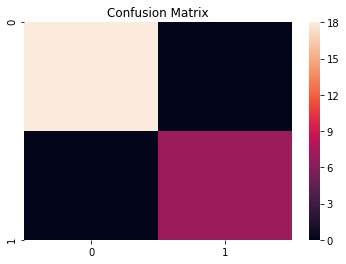

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



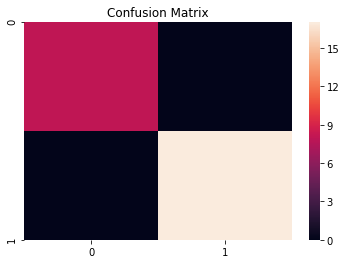

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



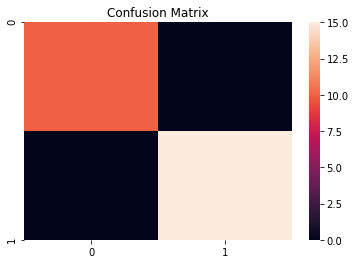

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.96000 
Precision = 0.96154 
Recall = 0.96154 
F1 - Score = 0.96000



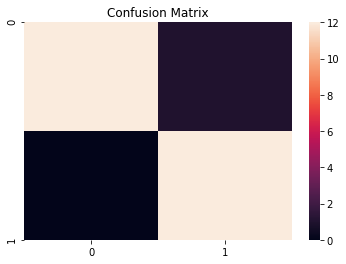

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.96000 
Precision = 0.96429 
Recall = 0.95833 
F1 - Score = 0.95974



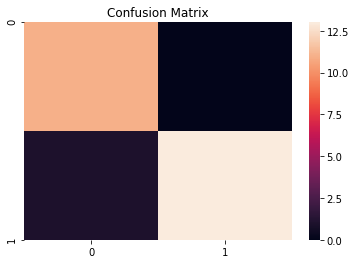

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



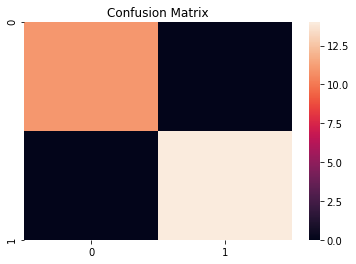

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.96000 
Precision = 0.96667 
Recall = 0.95455 
F1 - Score = 0.95895



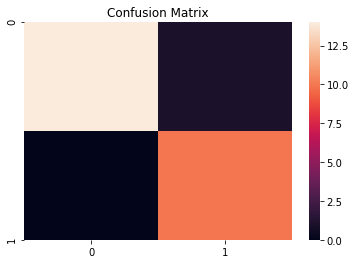

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 0.96000 
Precision = 0.96429 
Recall = 0.95833 
F1 - Score = 0.95974



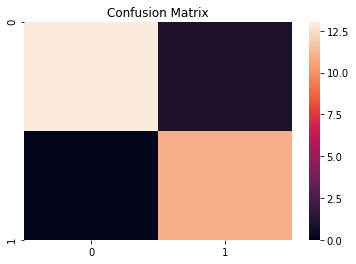

Shape of training =  (375, 2048)
Projected using  pca 

Dimension =  (375, 69)
Using  IMFDB  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



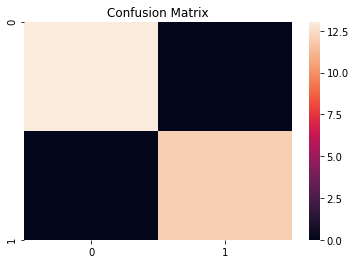

Shape of training =  (504, 2048)
Projected using  pca 

Dimension =  (504, 205)
Using  CFW  dataset
Validation Accuracy = 0.99405 
Precision = 0.99632 
Recall = 0.98485 
F1 - Score = 0.99046



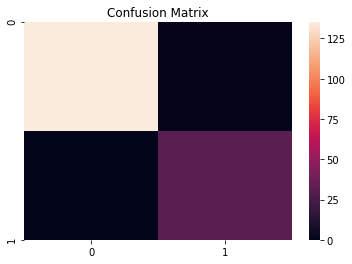

Shape of training =  (504, 2048)
Projected using  pca 

Dimension =  (504, 205)
Using  CFW  dataset
Validation Accuracy = 0.99405 
Precision = 0.99653 
Recall = 0.98000 
F1 - Score = 0.98805



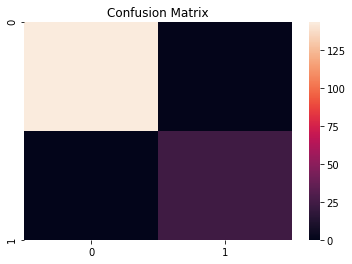

Shape of training =  (504, 2048)
Projected using  pca 

Dimension =  (504, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



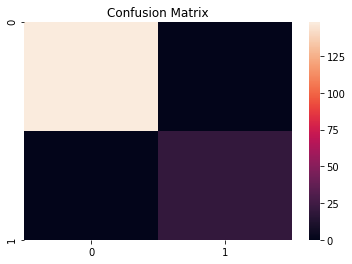

Shape of training =  (504, 2048)
Projected using  pca 

Dimension =  (504, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



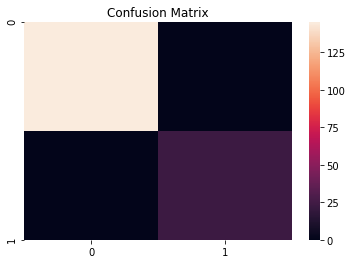

Shape of training =  (588, 2048)
Projected using  pca 

Dimension =  (588, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



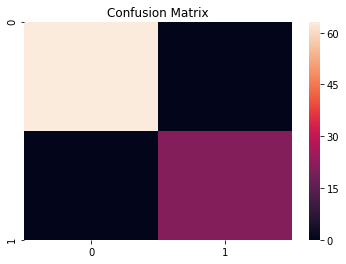

Shape of training =  (588, 2048)
Projected using  pca 

Dimension =  (588, 205)
Using  CFW  dataset
Validation Accuracy = 0.98810 
Precision = 0.99315 
Recall = 0.95833 
F1 - Score = 0.97481



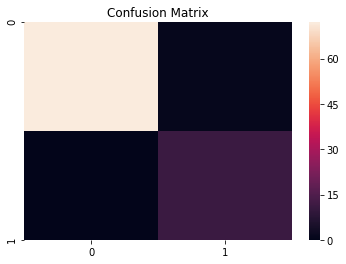

Shape of training =  (588, 2048)
Projected using  pca 

Dimension =  (588, 205)
Using  CFW  dataset
Validation Accuracy = 0.98810 
Precision = 0.99296 
Recall = 0.96429 
F1 - Score = 0.97794



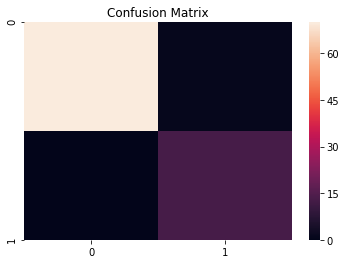

Shape of training =  (588, 2048)
Projected using  pca 

Dimension =  (588, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



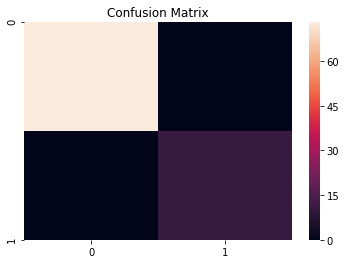

Shape of training =  (588, 2048)
Projected using  pca 

Dimension =  (588, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



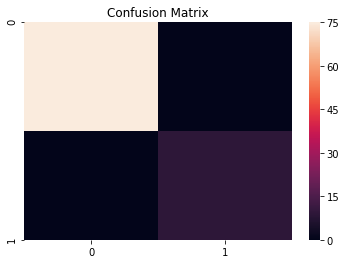

Shape of training =  (588, 2048)
Projected using  pca 

Dimension =  (588, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



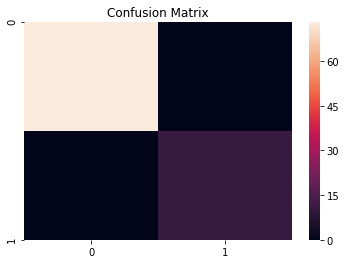

Shape of training =  (588, 2048)
Projected using  pca 

Dimension =  (588, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



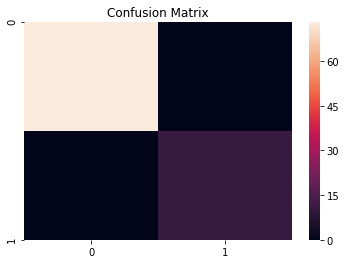

Shape of training =  (588, 2048)
Projected using  pca 

Dimension =  (588, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



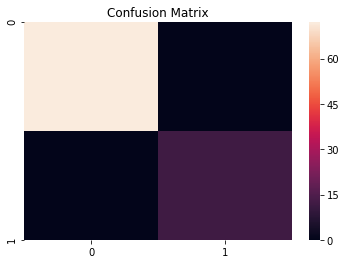

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



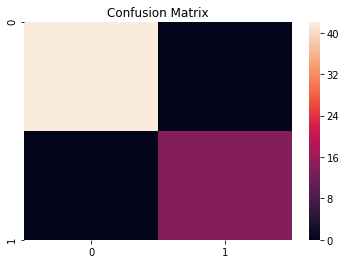

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 0.98214 
Precision = 0.98889 
Recall = 0.95833 
F1 - Score = 0.97264



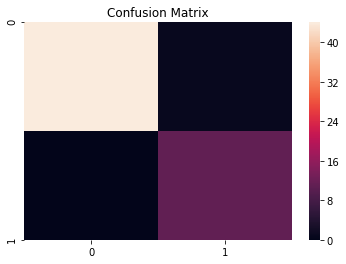

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



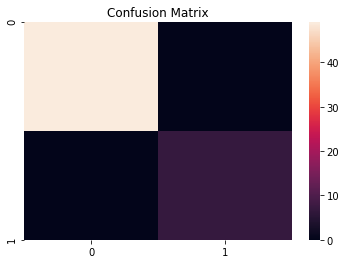

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 0.98214 
Precision = 0.98936 
Recall = 0.95000 
F1 - Score = 0.96831



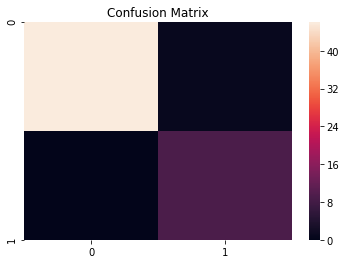

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



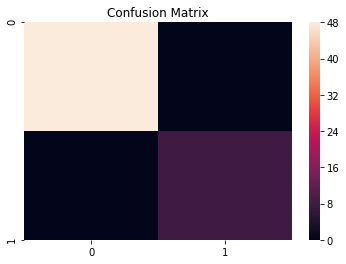

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



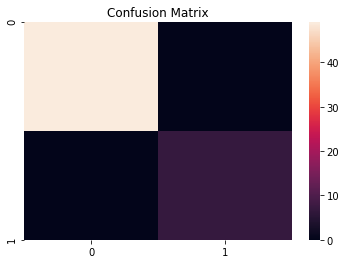

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



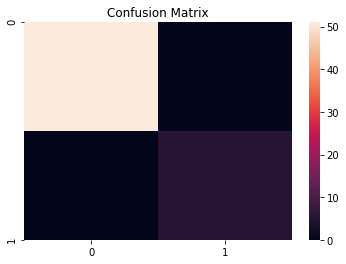

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



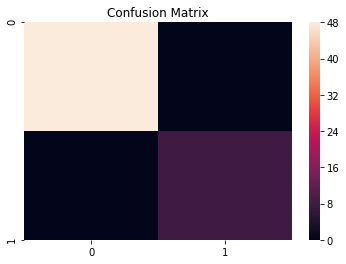

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



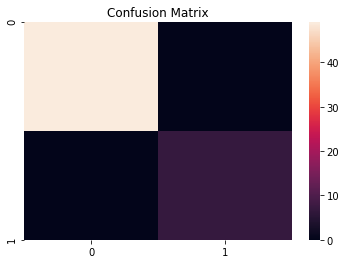

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



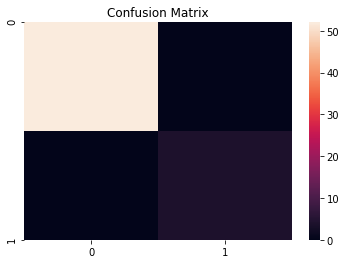

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



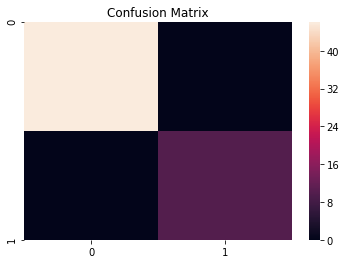

Shape of training =  (616, 2048)
Projected using  pca 

Dimension =  (616, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



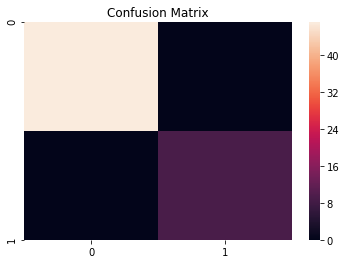

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



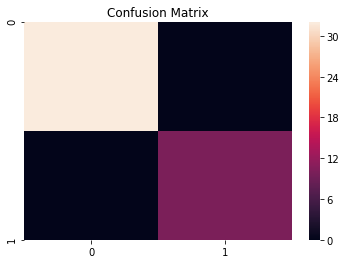

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



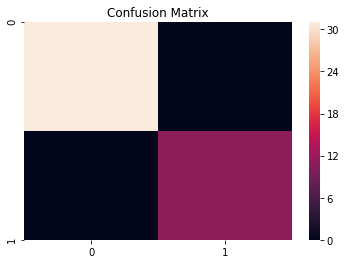

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 0.97619 
Precision = 0.98611 
Recall = 0.92857 
F1 - Score = 0.95450



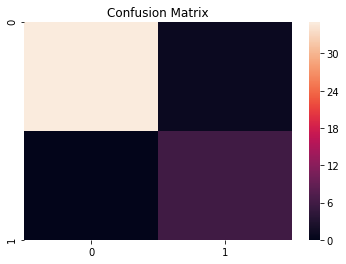

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



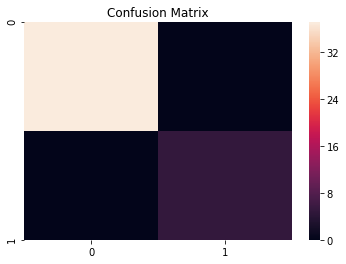

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 0.97619 
Precision = 0.98529 
Recall = 0.94444 
F1 - Score = 0.96313



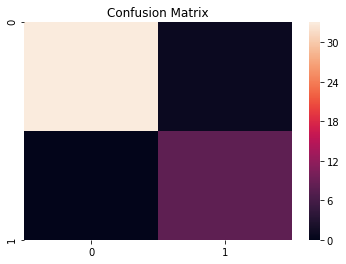

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



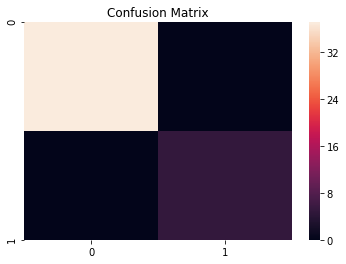

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



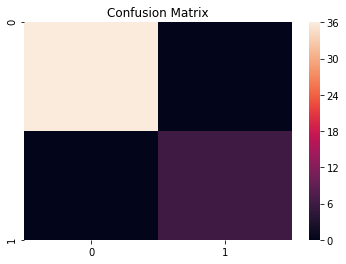

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



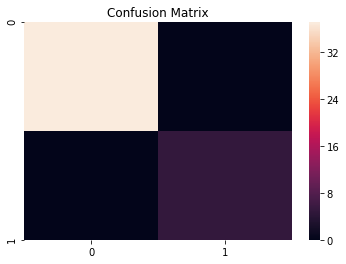

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



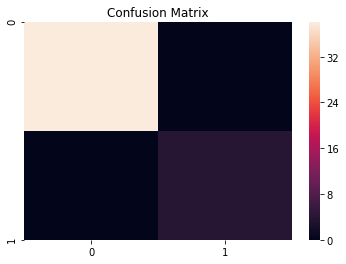

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



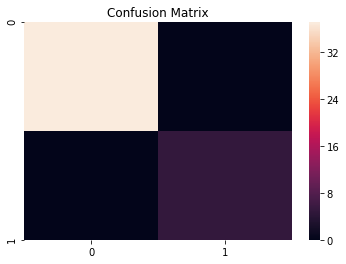

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



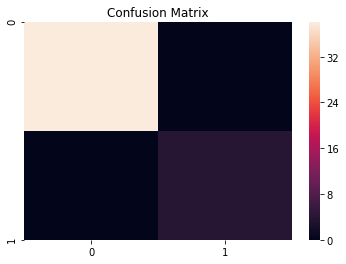

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



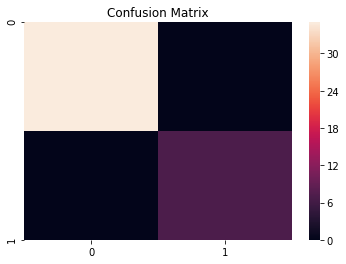

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



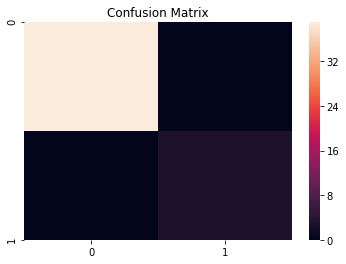

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



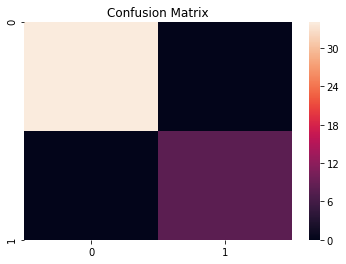

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



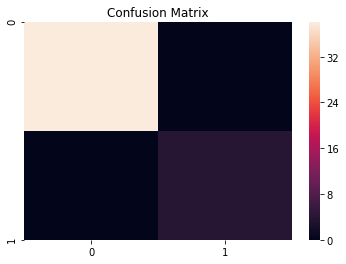

Shape of training =  (630, 2048)
Projected using  pca 

Dimension =  (630, 205)
Using  CFW  dataset
Validation Accuracy = 1.00000 
Precision = 1.00000 
Recall = 1.00000 
F1 - Score = 1.00000



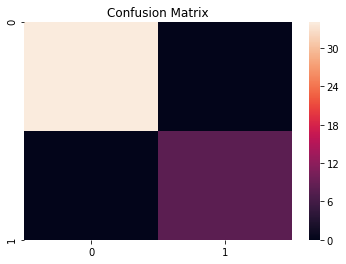

In [263]:
df_gender_IMFDB = kfold_cross_validation(get_resnet_features(dirpath[0]), y_gender_IMFDB, kfolds, 69, 'IMFDB','resnet','pca')
df_gender_CFW = kfold_cross_validation(get_resnet_features(dirpath[1]), y_gender_CFW, kfolds, 205, 'CFW','resnet','pca')

In [264]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
print('Variations in no. of folds using IMFDB dataset')
print(df_gender_IMFDB)
print(' ')
print('Variations in no. of folds using CFW dataset')
print(df_gender_CFW)
print(' ')

Variations in no. of folds using IMFDB dataset
    Accuracy  Error  F1 score
4       97.0    3.0  0.969925
8       98.0    2.0  0.979928
12     100.0    0.0  1.000000
16     100.0    0.0  1.000000
 
Variations in no. of folds using CFW dataset
    Accuracy  Error  F1 score
4      100.0    0.0       1.0
8      100.0    0.0       1.0
12     100.0    0.0       1.0
16     100.0    0.0       1.0
 


Projected using  pca 

Projected using  pca 



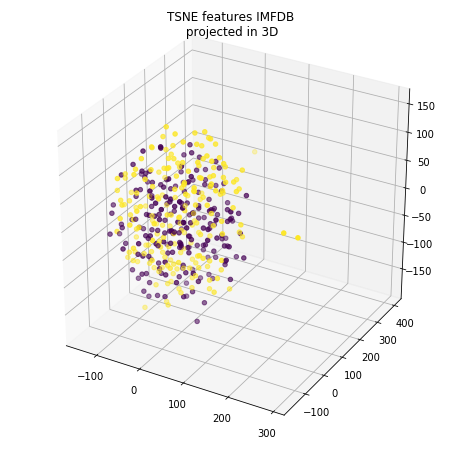

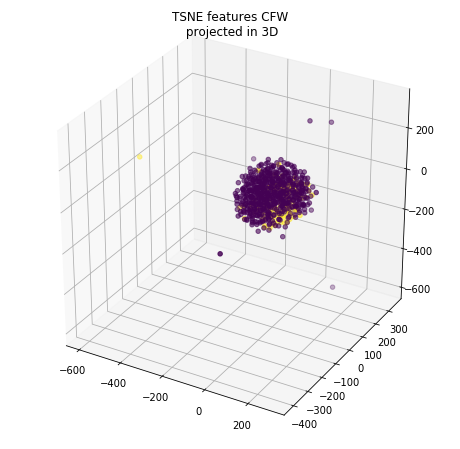

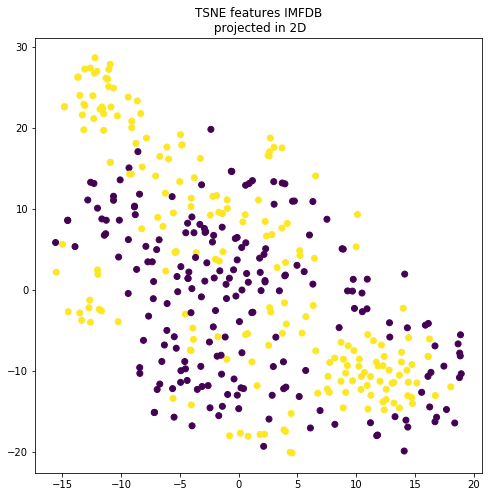

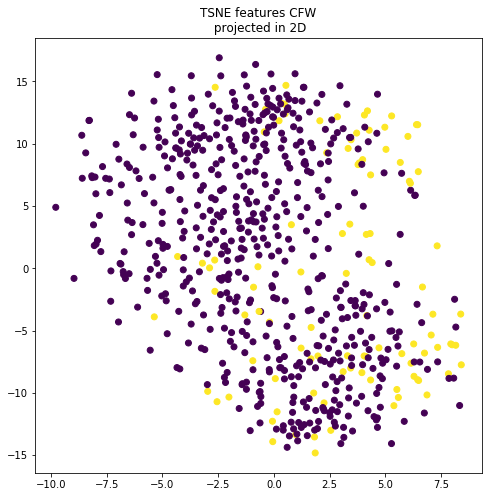

In [265]:
X_TSNE_gender_IMFDB_proj_pca,_ = project_images(get_resnet_features(dirpath[0]),y_gender_IMFDB,3,'pca')
X_TSNE_gender_CFW_proj_pca,_ = project_images(get_resnet_features(dirpath[1]),y_gender_CFW,3,'pca')

run_TSNE(X_gender_IMFDB,y_gender_IMFDB,'IMFDB')
run_TSNE(X_gender_CFW,y_gender_CFW,'CFW')

run_TSNE(X_gender_IMFDB,y_gender_IMFDB,'IMFDB',2)
run_TSNE(X_gender_CFW,y_gender_CFW,'CFW',2)

Projected using  pca 

Projected using  pca 



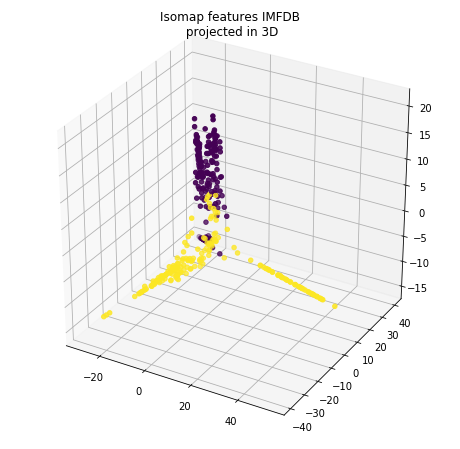

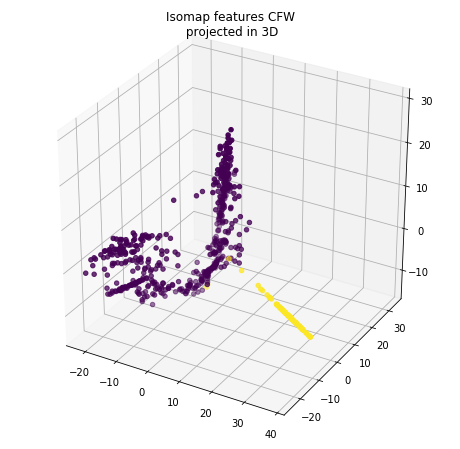

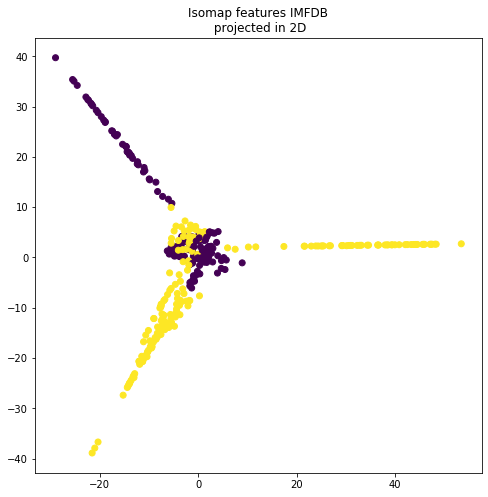

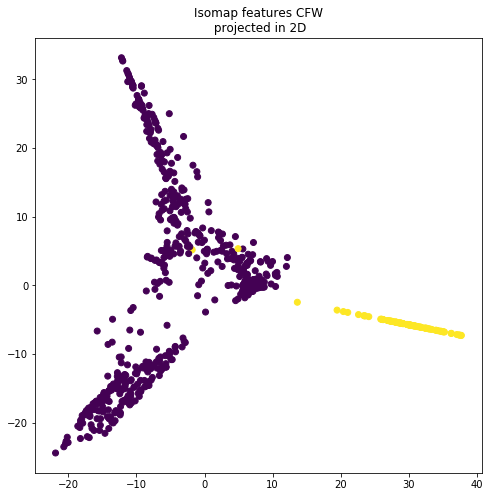

In [105]:
def run_Isomap(X,y,dataset,k=3):
    X_Isomap = Isomap(n_components=k).fit_transform(X)
    fig = plt.figure(figsize=(8,8))
    if k == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_Isomap[:,0],X_Isomap[:,1],X_Isomap[:,2], c=y)
        ax.set_title('Isomap features '+dataset+ '\n projected in 3D')
    elif k == 2:
        ax = fig.add_subplot(111)
        ax.scatter(X_Isomap[:,0],X_Isomap[:,1], c=y)
        ax.set_title('Isomap features '+dataset+ '\n projected in 2D')
    plt.show()

X_Isomap_gender_IMFDB_proj_pca,_ = project_images(get_resnet_features(dirpath[0]),y_gender_IMFDB,3,'pca')
X_Isomap_gender_CFW_proj_pca,_ = project_images(get_resnet_features(dirpath[1]),y_gender_CFW,3,'pca')

run_Isomap(X_Isomap_gender_IMFDB_proj_pca,y_gender_IMFDB,'IMFDB')
run_Isomap(X_Isomap_gender_CFW_proj_pca,y_gender_CFW,'CFW')

run_Isomap(X_Isomap_gender_IMFDB_proj_pca,y_gender_IMFDB,'IMFDB',2)
run_Isomap(X_Isomap_gender_CFW_proj_pca,y_gender_CFW,'CFW',2)

Dataset used :  IMFDB
First projection by  resnet
Projected using  pca 

No of wrongly classified samples =  3
No of correctly classified samples =  197
Showing Correctly predicted labels

Correct labels =  0  and  0
Correctly predicted labels =  0  and  0


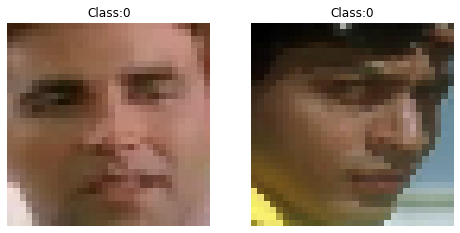

Showing Wrongly predicted labels

Correct labels =  0  and  0
Wrongly predicted labels =  1  and  1


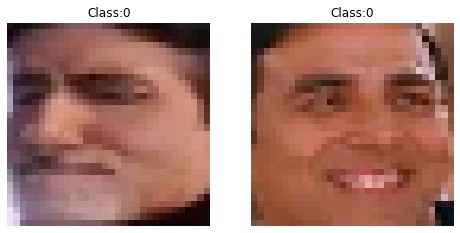

 
Dataset used :  CFW
First projection by  resnet
Projected using  pca 

No of wrongly classified samples =  2
No of correctly classified samples =  334
Showing Correctly predicted labels

Correct labels =  0  and  1
Correctly predicted labels =  0  and  1


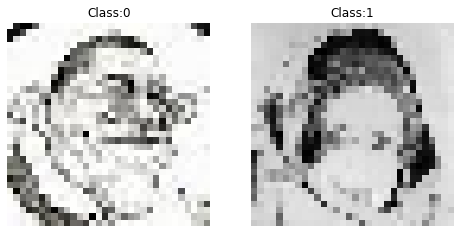

Showing Wrongly predicted labels

Correct labels =  1  and  1
Wrongly predicted labels =  0  and  0


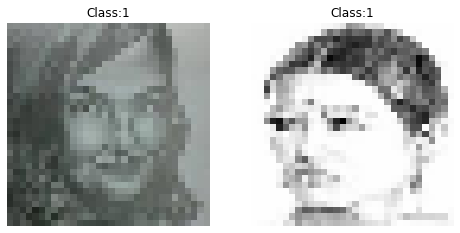

In [157]:
# Show quantitative results such as examples of correct prediction and wrong prediction


def show_demo(X, y, proj1, k, dataset, projection1, projection2 = None, test_size = 0.5):
    print('Dataset used : ', dataset)
    print('First projection by ', projection1)
    X_input_train, y_input_train, X_input_val, y_input_val = train_val_split(X,y, test_size=test_size)
    X = proj1
    X_train, y_train, X_val, y_val = train_val_split(X,y, test_size=test_size)
    X_train_proj, proj_model = project_images(X_train, y_train, k, projection2)
    X_val_proj = proj_model.transform(X_val)
    clf = Classifier()
    clf.train(X_train_proj, y_train)
    pred_val = clf.classify(X_val_proj)
    fail_idx = []
    pass_idx = []
    for i in range(len(y_val)):
        if pred_val[i]!=y_val[i]:
            fail_idx.append(i)
    
    for i in range(len(y_val)):
        if pred_val[i]==y_val[i]:
            pass_idx.append(i)
    
    if dataset is 'IMFDB':
        H,W,C = H_IMFDB, W_IMFDB, C_IMFDB
    elif dataset is 'CFW':
        H,W,C = H_CFW, W_CFW, C_CFW
    fail_idx = np.asarray(fail_idx)
    pass_idx = np.asarray(pass_idx)
    X_input_val = X_input_val.reshape((X_input_val.shape[0],H, W, C))
    print('No of wrongly classified samples = ',len(fail_idx))
    print('No of correctly classified samples = ',len(pass_idx))
    print('Showing Correctly predicted labels\n')
    pass_ind = np.random.randint(0,len(pass_idx),2)
    print('Correct labels = ',y_val[pass_idx[pass_ind[0]]],' and ',y_val[pass_idx[pass_ind[1]]])
    print('Correctly predicted labels = ',pred_val[pass_idx[pass_ind[0]]],' and ',pred_val[pass_idx[pass_ind[1]]])
    disply_images(X_input_val[pass_idx[pass_ind],...],y_val[pass_idx[pass_ind]], row=1,col=2)
    
    if (len(fail_idx) == 0):
        print('No missclassifications available')
        print(' ')
        return
    
    print('Showing Wrongly predicted labels\n')
    fail_ind = np.random.randint(0,len(fail_idx),2)
    print('Correct labels = ',y_val[fail_idx[fail_ind[0]]],' and ',y_val[fail_idx[fail_ind[1]]])
    print('Wrongly predicted labels = ',pred_val[fail_idx[fail_ind[0]]],' and ',pred_val[fail_idx[fail_ind[1]]])
    disply_images(X_input_val[fail_idx[fail_ind],...],y_val[fail_idx[fail_ind]], row=1,col=2)
    print(' ')

    
show_demo(X_gender_IMFDB,y_gender_IMFDB,get_resnet_features(dirpath[0]),69,'IMFDB','resnet','pca')
show_demo(X_gender_CFW,y_gender_CFW,get_resnet_features(dirpath[1]),205,'CFW','resnet','pca')